In [2]:
## !/opt/miniconda3/envs/thesis/bin python

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.ticker import MultipleLocator

%matplotlib inline
%config InlineBackend.figure_format='retina'


import os
import shutil
import tempfile
from contextlib import contextmanager

import sys
from subprocess import Popen, PIPE, CalledProcessError, run
# from io import StringIO
import time
from gvar import gvar,sdev
from UWerr import UWerr
from ruamel.yaml import YAML

from IPython.display import HTML, display
from ipywidgets.widgets import Output
import io

In [3]:
from matplotlib import rc, rcParams
rc('text',usetex=True) #related to latex for the labels
rcParams['font.size'] = 20.0
rcParams['axes.titlesize'] = 22.0
rcParams['xtick.labelsize'] = 20.0
rcParams['ytick.labelsize'] = 20.0
rcParams['axes.labelsize'] = 20.0
rcParams['legend.fontsize'] = 22.0
rcParams["image.cmap"] = 'gist_rainbow'

In [37]:
class Observable(object):
    def __init__(self,label,func,scale = 'linear'):
        self.label = label
        self.func = func
        self.scale = scale

    def __call__(self, data):
        average = self.func(data)
        return gvar(average, self.jackknife(data, average))

    def jackknife(self, data, average=None, tau=0.5):
        cumsum = 0
        if average is None: 
            average = self.func(data)
        for i in data.index:
            cumsum += ( self.func(data.drop(i)) - average )**2
#         return np.sqrt(2 * tau * cumsum * data.size)
        return np.sqrt(2 * (data.size - 1) / data.size * tau * cumsum)

global_observables = dict(
    S               =   Observable(r"S", 
                                   lambda data: np.mean(data['S']/(data['beta']*data['L']**2)) ),
    internal_energy =   Observable(r"E", 
                                   lambda data: np.mean(data['S']/(0.5*data['beta']*data['L']**2)) ),
    chi_m           =   Observable(r"\chi_m", 
                                   lambda data: np.mean(data['chi_m']), scale='log'),
    delta_m         =   Observable(r"\delta_m",
                            lambda data,beta:
                                2 * 10**5 * beta**4 * np.exp(-4*np.pi*beta) * np.mean(data['chi_m'])/(data['L']**2),
                            scale = 'log'),
    Q               =   Observable(r"\langle Q \rangle", 
                                   lambda data: np.mean(data['Q'])),
    chi_t           =   Observable(r"\langle Q^2 \rangle", 
                                   lambda data: np.mean(data['Q']**2), scale='log')
    

)

# @contextmanager
# def named_pipes(n=1):
#     dirname = tempfile.mkdtemp()
#     try:
#         paths = [os.path.join(dirname, 'named_pipe' + str(i)) for i in range(n)]
#         for path in paths:
#             os.mkfifo(path)
#         yield paths
#     finally:
#         shutil.rmtree(dirname)

def print_stats():
    print(f"{measurements} measurements every {record_rate} sweeps, {thermalization} sweep thermalization.")
    
def get_data(output_file="data"):
    data = pd.read_csv("outputs/"+output_file+".csv")
    data = data.round({'Q':0}).astype({'Q':'int32'})
    return data

In [9]:
bietenholz_params = pd.DataFrame(data = {
    'L' : [24, 36, 54, 80, 120, 180, 270, 404],
    'beta' : [1.263, 1.370, 1.458, 1.535, 1.607, 1.677, 1.743, 1.807],
    't0' : [0.1, 0.225, 0.506, 1.111, 2.5, 5.625, 12.656, 28.336],
    'xi2': [3.96, 6.01, 8.93, 13.24, 19.77, 30.01, 44.97, 67.66],
    'xi2_err' : [.01,.01,.04,.04,.11,.18,.24,.31]
})
colors = ['black','red','blue','yellow','orange','cyan','green','purple']

In [6]:
cores = 1

taus = np.linspace(0,10,11)
#taus = [0.]
#taus = np.array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 20.])

measurements = 10000
thermalization = 1000
record_rate = 50

# Generate 

In [27]:
yaml = YAML()
yaml.indent(sequence=4, offset=2)

def i_filename(beta): return f"inputs/params{beta:.1f}.yml"

processes = []

assert measurements % cores == 0

betas = [0.5, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.5]
L = 100
measurements = 1000
thermalization = 1000
record_rate = 50

for i, beta in enumerate(betas):
    yaml_data =  {
            'beta': float(beta),
            'L':    L,
            'measurements': measurements,
            'thermalization': thermalization,
            'record_rate': record_rate,
            'taus': [0.]
    }
    with open(i_filename(beta), 'w') as yaml_file:
        yaml.dump(yaml_data, yaml_file)

In [264]:
10000 / 10

1000.0

In [268]:
yaml = YAML()
yaml.indent(sequence=4, offset=2)

def i_filename(L,i,j): return f"inputs/gf/params{L}-{i}_{j}.yml"

processes = []
cores = 10
multiplicity = 10

assert measurements % cores == 0

for i, p in bietenholz_params[-1:].iterrows():
    print(p.L)
    for j in range(multiplicity):
        for k in range(cores):
            scaled_taus = [float(tau*p.t0) for tau in taus]
            yaml_data =  {
                    'beta': float(p.beta),
                    'L':    float(p.L),
                    'measurements': measurements//cores//multiplicity,
                    'thermalization': thermalization,
                    'record_rate': record_rate,
                    'taus': scaled_taus
            }
            print("Wrote",i_filename(p.L, j, k))
            with open(i_filename(p.L, j, k), 'w') as yaml_file:
                yaml.dump(yaml_data, yaml_file)

404.0
Wrote inputs/gf/params404.0-0_0.yml
Wrote inputs/gf/params404.0-0_1.yml
Wrote inputs/gf/params404.0-0_2.yml
Wrote inputs/gf/params404.0-0_3.yml
Wrote inputs/gf/params404.0-0_4.yml
Wrote inputs/gf/params404.0-0_5.yml
Wrote inputs/gf/params404.0-0_6.yml
Wrote inputs/gf/params404.0-0_7.yml
Wrote inputs/gf/params404.0-0_8.yml
Wrote inputs/gf/params404.0-0_9.yml
Wrote inputs/gf/params404.0-1_0.yml
Wrote inputs/gf/params404.0-1_1.yml
Wrote inputs/gf/params404.0-1_2.yml
Wrote inputs/gf/params404.0-1_3.yml
Wrote inputs/gf/params404.0-1_4.yml
Wrote inputs/gf/params404.0-1_5.yml
Wrote inputs/gf/params404.0-1_6.yml
Wrote inputs/gf/params404.0-1_7.yml
Wrote inputs/gf/params404.0-1_8.yml
Wrote inputs/gf/params404.0-1_9.yml
Wrote inputs/gf/params404.0-2_0.yml
Wrote inputs/gf/params404.0-2_1.yml
Wrote inputs/gf/params404.0-2_2.yml
Wrote inputs/gf/params404.0-2_3.yml
Wrote inputs/gf/params404.0-2_4.yml
Wrote inputs/gf/params404.0-2_5.yml
Wrote inputs/gf/params404.0-2_6.yml
Wrote inputs/gf/params

Run

In [41]:
for i, (L, beta, t0) in enumerate(zip(Ls, betas, t0s)):
    cmd = ["mpiexec",
            "-n", str(cores),
            "cpp_code/bin/sweep",
            "-i", i_filename(i),
            "-o", o_filename(i)]
    print(' '.join(cmd))
    o_filenames.append(o_filename(i))
#     with open(path, 'wb', 0) as pipe:
#         print(path)
    processes.append( Popen(cmd, stdout=PIPE, stderr=PIPE, bufsize=1, universal_newlines=True) )

mpiexec -n 1 cpp_code/bin/sweep -i inputs/gf/params_0.yml -o outputs/gf/params_0.csv
mpiexec -n 1 cpp_code/bin/sweep -i inputs/gf/params_1.yml -o outputs/gf/params_1.csv
mpiexec -n 1 cpp_code/bin/sweep -i inputs/gf/params_2.yml -o outputs/gf/params_2.csv
mpiexec -n 1 cpp_code/bin/sweep -i inputs/gf/params_3.yml -o outputs/gf/params_3.csv


In [42]:
# Montior progress
progresses = [Output(layout={'border': '1px solid black'}) for _ in processes]
[display(progress) for progress in progresses]
delay = 0.1
started = [False for _ in processes]
finished = [False for _ in processes]
last_prints = [time.time() for _ in processes]

        
while not all(finished):
    for i,p in enumerate(processes):
        line = p.stdout.readline()
        if "Working" in line:
            if (time.time() - last_prints[i]) > delay:
                progresses[i].clear_output()
                if "Working" in line:
                    if not started[i]:
                        started[i] = True
                    with progresses[i]:
                        print(f" {i}> " + line)
                last_prints[i] = time.tdime()
        else:
            progresses[i].clear_output()
            if started[i]:
                finished[i] = True
            with progresses[i]:
                print(f" {i}| " + line)
            

Output(layout=Layout(border='1px solid black'))

Output(layout=Layout(border='1px solid black'))

Output(layout=Layout(border='1px solid black'))

Output(layout=Layout(border='1px solid black'))

In [43]:
# # Combine the files
with open(output_file, 'w') as sumfile:
    needs_header = True
    for ofilename in o_filenames:
        with open(ofilename,'r') as ofile:
            if needs_header:
                sumfile.write(next(ofile))
                needs_header = False
            else:
                next(ofile)
            sumfile.write(ofile.read())
        os.remove(ofilename)

        
print_stats()

FileNotFoundError: [Errno 2] No such file or directory: 'outputs/gf/params_0.csv'

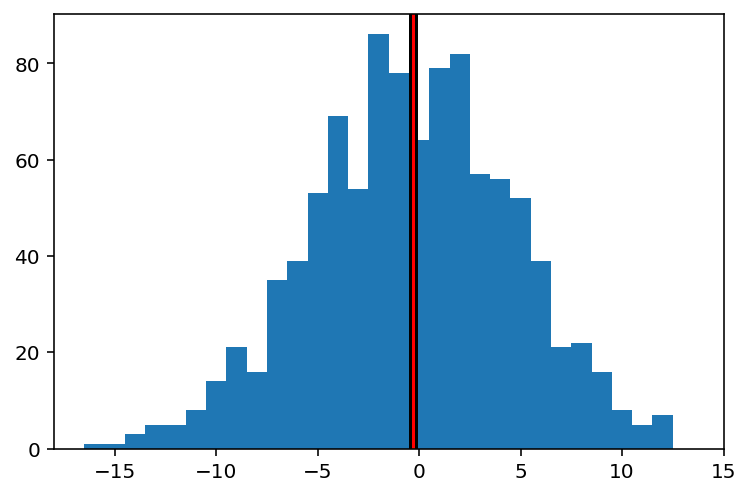

In [65]:
L = 270

def bins(d): return np.arange( np.amin(d)-0.5,np.amax(d)+0.5 )
Q_data = data[(data.tau==0.) & (data.L==L)]
Q_vals = Q_data[['Q']].values[:,0]
plt.hist(Q_vals, bins=bins(Q_vals))
gv = global_observables['Q'](Q_data)
plt.axvline(gv.mean,c='r')
plt.axvline(gv.sdev+gv.mean,c='k')
plt.axvline(-gv.sdev+gv.mean,c='k')


NameError: name 'Ls' is not defined

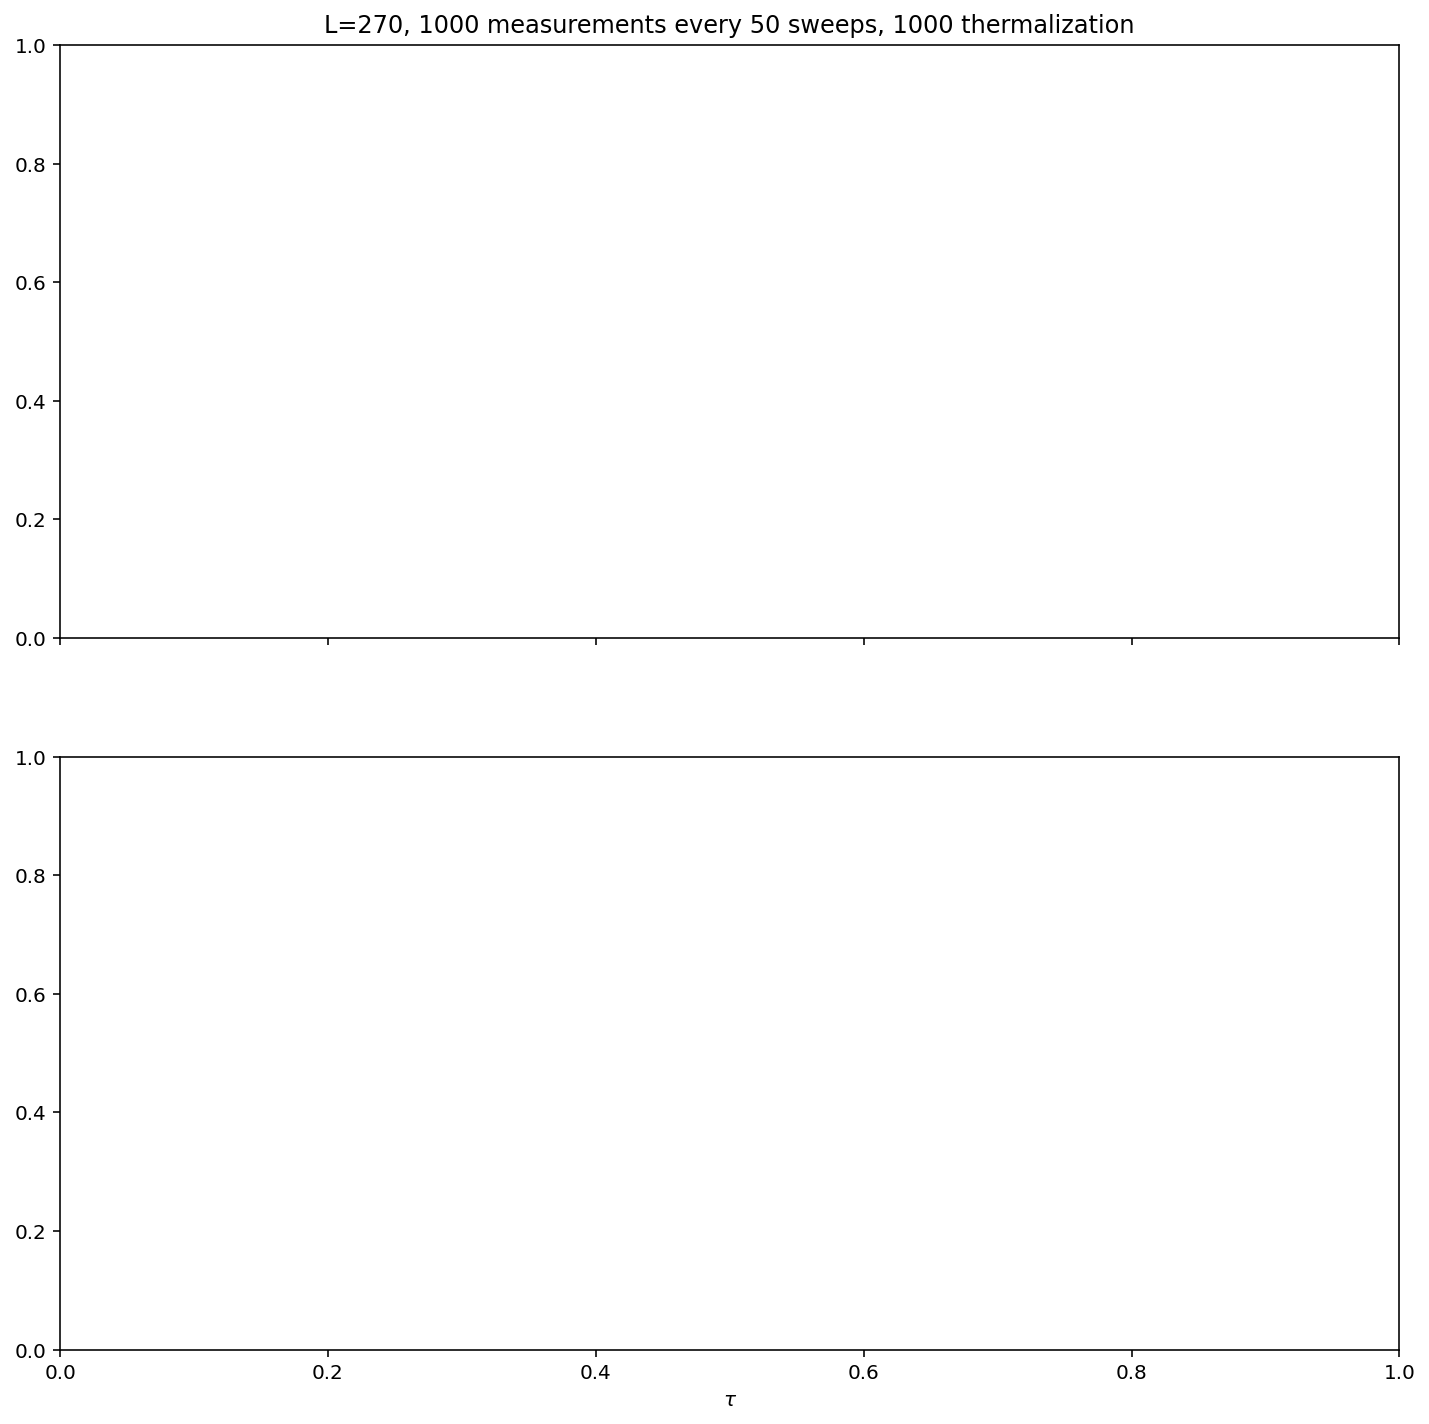

In [69]:
observ_names = ['Q','chi_t']
observ_objs = [global_observables[o] for o in observ_names]

fig,axes = plt.subplots(len(observ_names),1,figsize=(12,6*len(observ_names)), sharex=True, squeeze=False)
axes = [ax for row in axes for ax in row] # flatten axes

axes[0].set_title(f"L={L}, {measurements} measurements every {record_rate} sweeps, {thermalization} thermalization")
axes[-1].set_xlabel(r"$\tau$")


for ax, O in zip(axes, observ_objs):
    for i,p in bietenholz_params.iterrows():
        if L==120: break
        d = []
        for tau in taus:
            trial = data[(round(data['tau'],10) == round(tau*t0,10)) & (data['L'] == L)]
            if trial.size == 0:
                print(tau,L)
                raise Exception("trial returned zero data points")
            d.append(O(trial))

        ax.errorbar(taus, [x.mean for x in d], yerr=[x.sdev for x in d], fmt='.', c=c, label=f"$L={L}$", capsize=3.)
        ax.legend()

    ax.set_xlabel(r'$\tau / \tau_0$')
    ax.set_ylabel('$'+O.label+'$')
    ax.set_yscale(O.scale)
    ax.tick_params(axis='y', which='both', left=True, right=True)
    #ax.set_xlim((0.4, 2.6))
    
axes[0].axhline(0)
axes[1].set_ylim((1,100))

plt.show()

10000 measurements every 50 sweeps, 1000 thermalization


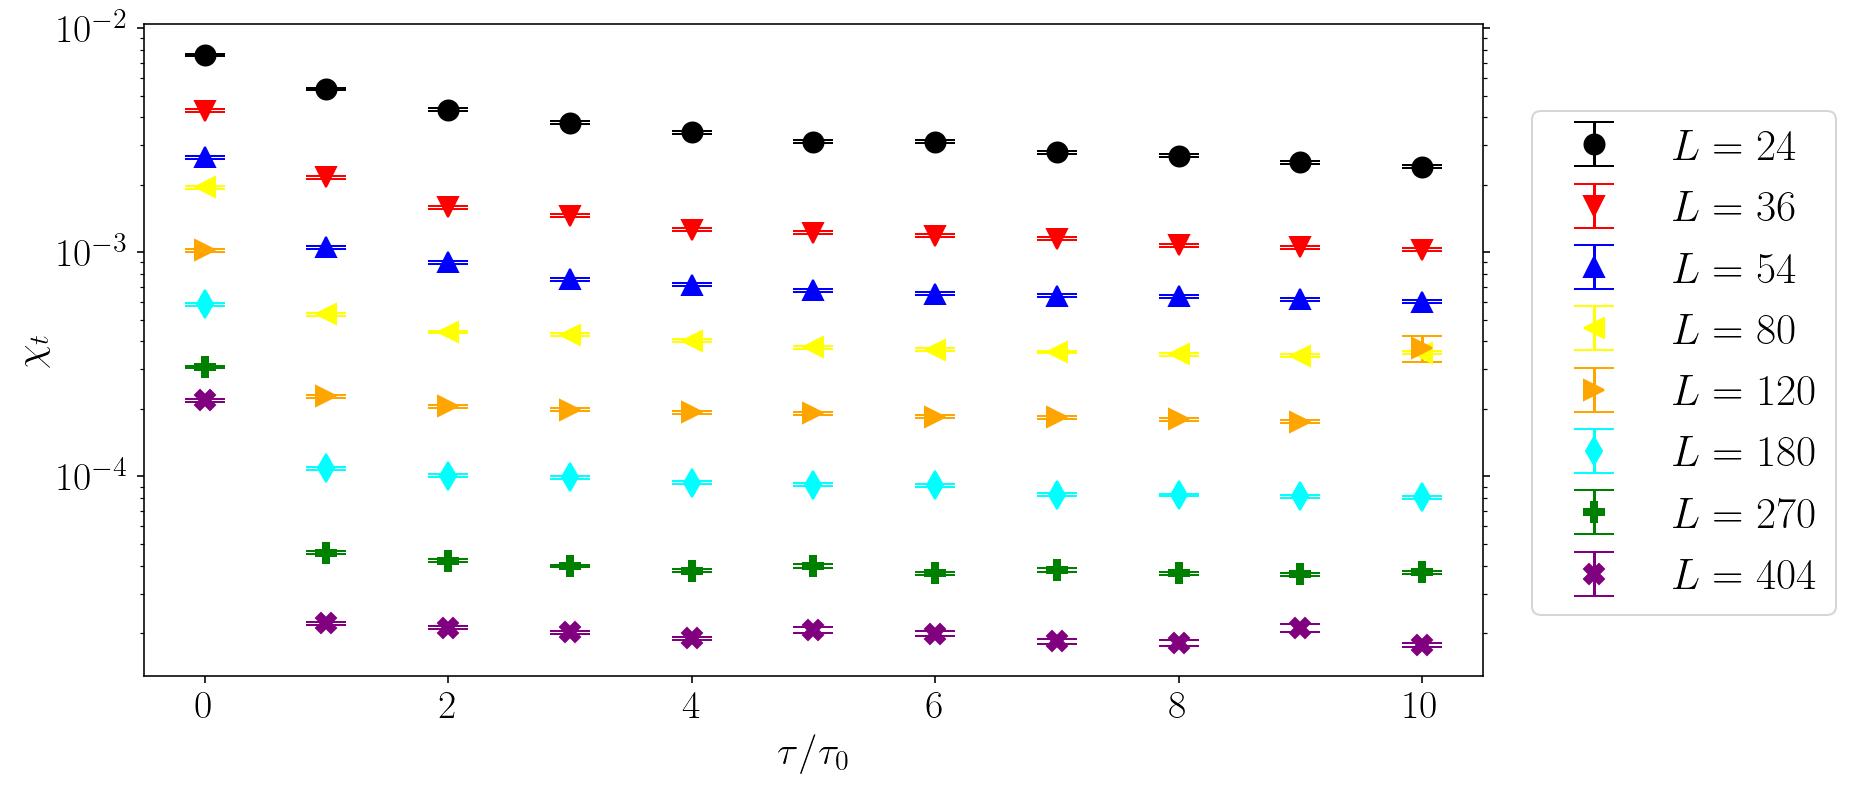

In [72]:
# Reproduce Bietenholz 4

data = get_data("data5")

#observ_names = ['Q','chi_t']
observ_names = ['chi_t']
observ_objs = [global_observables[o] for o in observ_names]

fig,axes = plt.subplots(len(observ_names),1,figsize=(12,6*len(observ_names)), sharex=True, squeeze=False)
axes = [ax for row in axes for ax in row] # flatten axes

#axes[0].set_title(f"{measurements} measurements every {record_rate} sweeps, {thermalization} thermalization")
print(f"{measurements} measurements every {record_rate} sweeps, {thermalization} thermalization")
axes[-1].set_xlabel(r"$\tau$")

markers = ['o','v','^','<','>','d','P','X']

for ax, O in zip(axes, observ_objs):
    for i,p in bietenholz_params.iterrows():
        d = []
    
        if data[data['L'] == p.L].size == 0:
            continue
            
        plotrange = taus
        for tau in plotrange:
        #for tau in taus:
            trial = data[(round(data['tau'],10) == round(tau*p.t0,10)) & (data['L'] == p.L)]
            d.append(O(trial)/p.L**2)
            #d.append(gvar(1.,0.))

        ax.errorbar(plotrange, [x.mean for x in d], yerr=[x.sdev for x in d], c=colors[i], marker=markers[i], ls='', label=f"$L={int(p.L)}$", ms=10.,capsize=10.)
        ax.legend(bbox_to_anchor = (1.28, 0.9))

    ax.set_xlabel(r'$\tau / \tau_0$')
    #ax.set_ylabel('$'+O.label+'$')
    ax.set_ylabel(r'$\chi_t$')
    ax.set_yscale(O.scale)
    ax.tick_params(axis='y', which='both', left=True, right=True)
    #ax.set_xlim((0.4, 2.6))
    
#axes[0].axhline(0)
#axes[0].set_ylim((1,100))

plt.show()

10000 measurements every 50 sweeps, 1000 thermalization


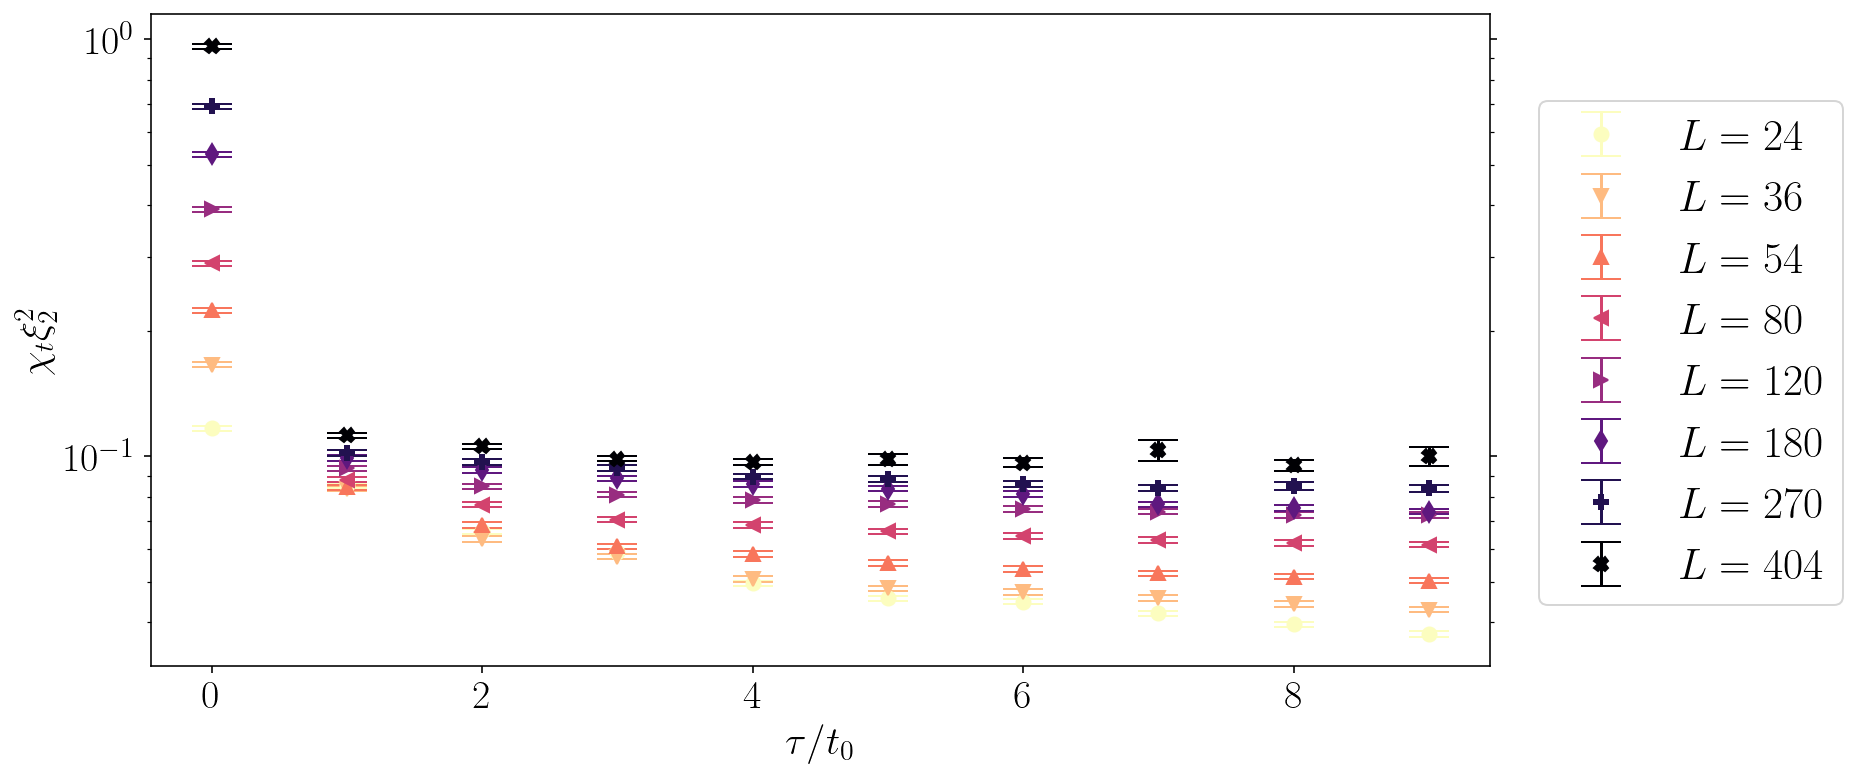

In [44]:
# Reproduce Bietenholz 5

data = get_data("data5_fixed")

#observ_names = ['Q','chi_t']
observ_names = ['chi_t']
observ_objs = [global_observables[o] for o in observ_names]

fig,axes = plt.subplots(len(observ_names),1,figsize=(12,6*len(observ_names)), sharex=True, squeeze=False)
axes = [ax for row in axes for ax in row] # flatten axes

#axes[0].set_title(f"{measurements} measurements every {record_rate} sweeps, {thermalization} thermalization")
print(f"{measurements} measurements every {record_rate} sweeps, {thermalization} thermalization")
axes[-1].set_xlabel(r"$\tau$")

markers = ['o','v','^','<','>','d','P','X']
cs = cm.get_cmap('magma_r', len(bietenholz_params))

for ax, O in zip(axes, observ_objs):
    for i,p in bietenholz_params.iterrows():
        d = []
    
        if data[data['L'] == p.L].size == 0:
            continue
            
        #for tau in taus[:2]:
        for tau in taus[:-1]:
            trial = data[(round(data['tau'],10) == round(tau*p.t0,10)) & (data['L'] == p.L)]
            d.append(O(trial)/p.L**2*p.xi2**2)
            #d.append(gvar(1.,0.))

        ax.errorbar(taus[:-1], 
                    [x.mean for x in d], yerr=[x.sdev for x in d], 
                    ls='', 
                    c=cs(i), 
                    marker=markers[i],
                    label=f"$L={int(p.L)}$", 
                    ms=7., 
                    capsize=10.
                   )
        ax.legend(bbox_to_anchor = (1.28, 0.9))

    ax.set_xlabel(r'$\tau / t_0$')
    #ax.set_ylabel('$'+O.label+'$')
    ax.set_ylabel(r'$\chi_t \xi_2^2$')
    ax.set_yscale(O.scale)
    ax.tick_params(axis='y', which='both', left=True, right=True)
    #ax.set_xlim((0.4, 2.6))
    
#axes[0].axhline(0)
#axes[0].set_ylim((1,100))

plt.show()

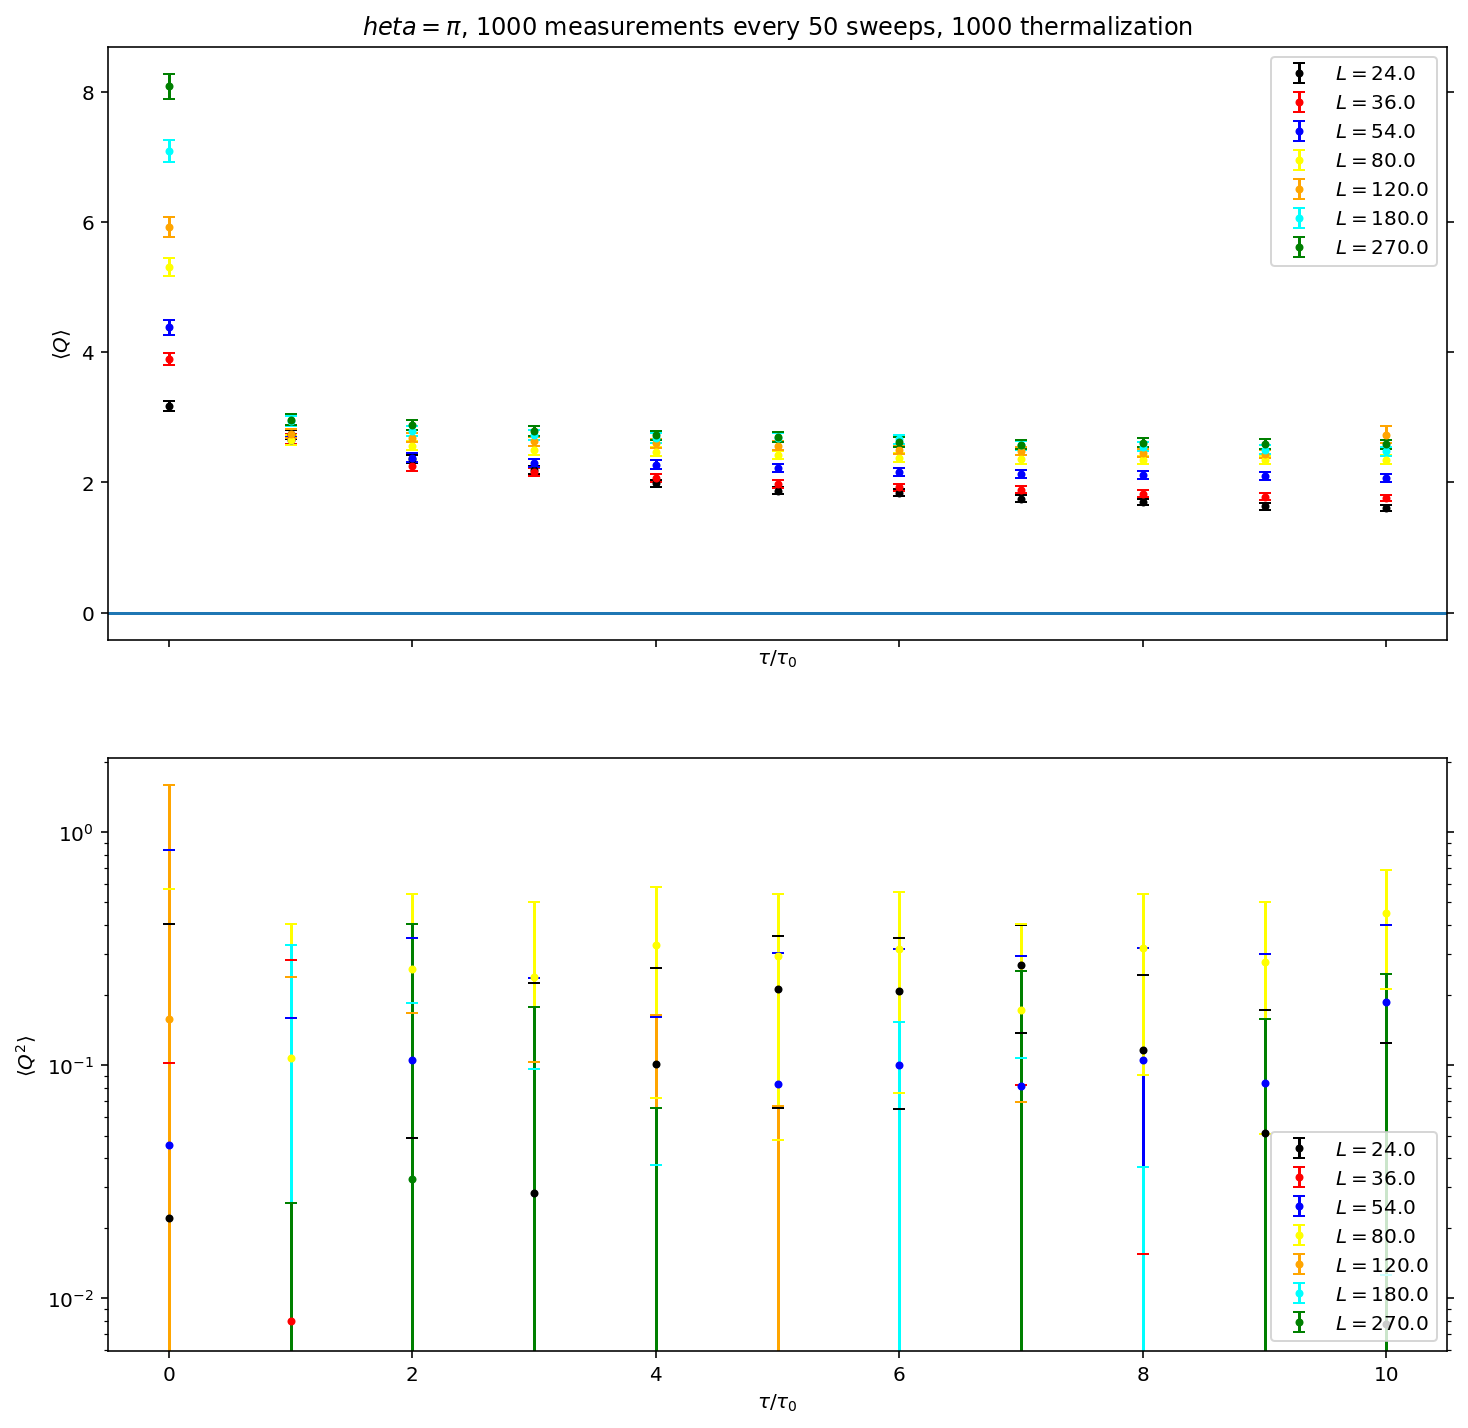

In [26]:
# Reproduce Bietenholz, theta = pi

output_file = "outputs/data.csv"
data = pd.read_csv(output_file)

observ_names = ['Q','chi_t']
observ_objs = [global_observables[o] for o in observ_names]

fig,axes = plt.subplots(len(observ_names),1,figsize=(12,6*len(observ_names)), sharex=True, squeeze=False)
axes = [ax for row in axes for ax in row] # flatten axes

axes[0].set_title(f"$\\theta=\pi$, {measurements} measurements every {record_rate} sweeps, {thermalization} thermalization")
axes[-1].set_xlabel(r"$\tau$")


for ax, O in zip(axes, observ_objs):
    for i,p in bietenholz_params.iterrows():
        #if p.L==120: 
        d = []
        
        if data[data['L'] == p.L].size == 0:
              continue
        
        for tau in taus:
            trial = data[(round(data['tau'],10) == round(tau*p.t0,10)) & (data['L'] == p.L)]
                
            # this line is different
            d.append( O(trial[trial.Q>0]) - O(trial[trial.Q<0]) )

        ax.errorbar(taus, [x.mean for x in d], yerr=[x.sdev for x in d], fmt='.', c=colors[i], label=f"$L={p.L}$", capsize=3.)
        ax.legend()
        
    ax.set_xlabel(r'$\tau / \tau_0$')
    ax.set_ylabel('$'+O.label+'$')
    ax.set_yscale(O.scale)
    ax.tick_params(axis='y', which='both', left=True, right=True)
    #ax.set_xlim((0.4, 2.6))
    
axes[0].axhline(0)
#axes[1].set_ylim((1,100))

plt.show()

In [108]:
betas = bietenholz_params.beta.

0    1.263
1    1.370
2    1.458
3    1.535
4    1.607
5    1.677
6    1.743
7    1.807
Name: beta, dtype: float64

In [109]:
data

,tau,beta,L,S,Q,chi_m,F
0,0,1.263,24,748.380,-6,-80.3925,-79.8068
1,0,1.263,24,750.093,-5,-83.9944,-83.4713
2,0,1.263,24,745.522,0,-76.2707,-75.8601
3,0,1.263,24,719.024,-4,-54.1922,-54.0803
4,0,1.263,24,729.033,-5,-55.2504,-55.1955
...,...,...,...,...,...,...,...
995,0,1.807,404,173522.000,4,24457.7000,24456.2000
996,0,1.807,404,173602.000,-4,24480.7000,24479.2000
997,0,1.807,404,173621.000,5,24598.8000,24597.3000
998,0,1.807,404,173950.000,-2,24675.6000,24674.1000


24
500
tau_int: 4.430410520355903


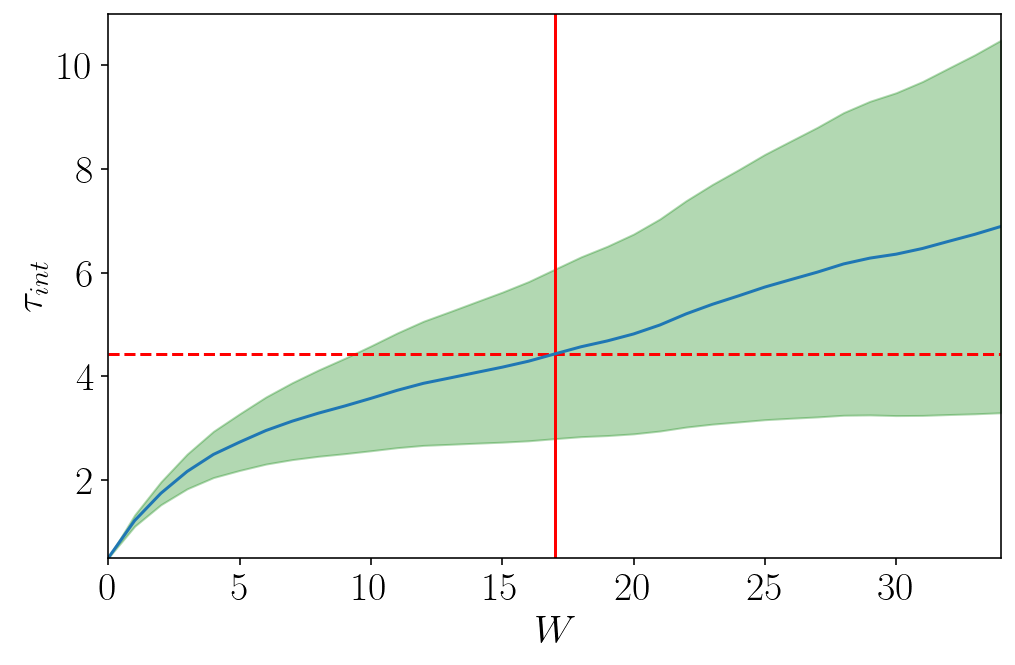

404
500
tau_int: 12.809367995661017


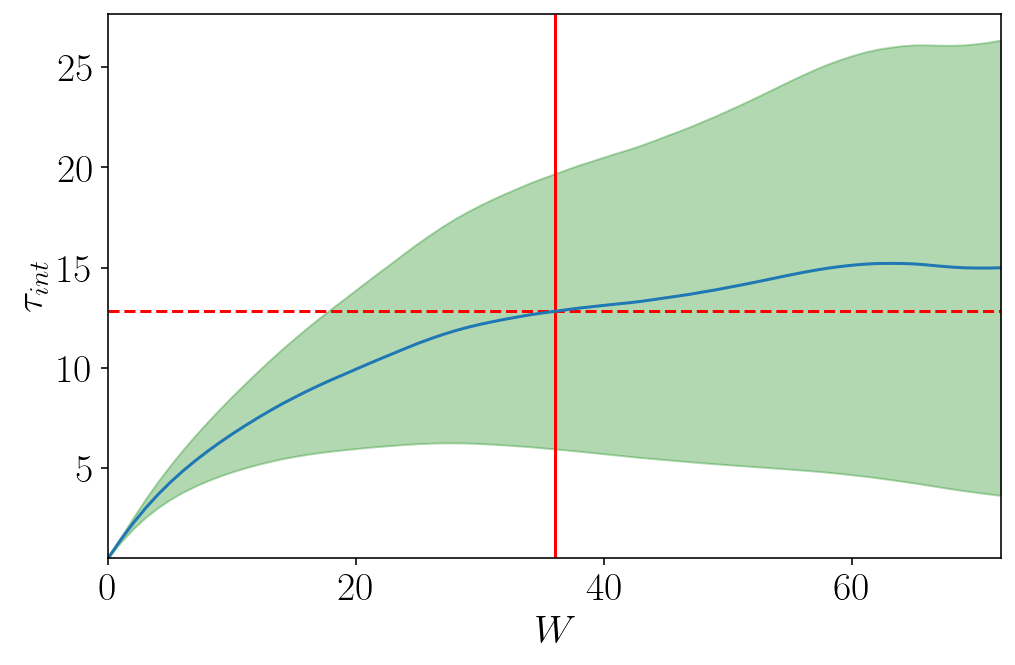

In [121]:
data = get_data("data_auto")
def plot_autocorrelation(trial, name=""):
    series = trial.chi_m.to_numpy()
    UWerr(series, name=name, plot=True)

#print_stats()
for L in data.L.unique():
    print(L)
    trial = data[data.L == L]
    print(trial.chi_m.size)
    #name = f"$\\chi_m$: $L={L}$, $\\beta={beta}$"
    plot_autocorrelation(trial)


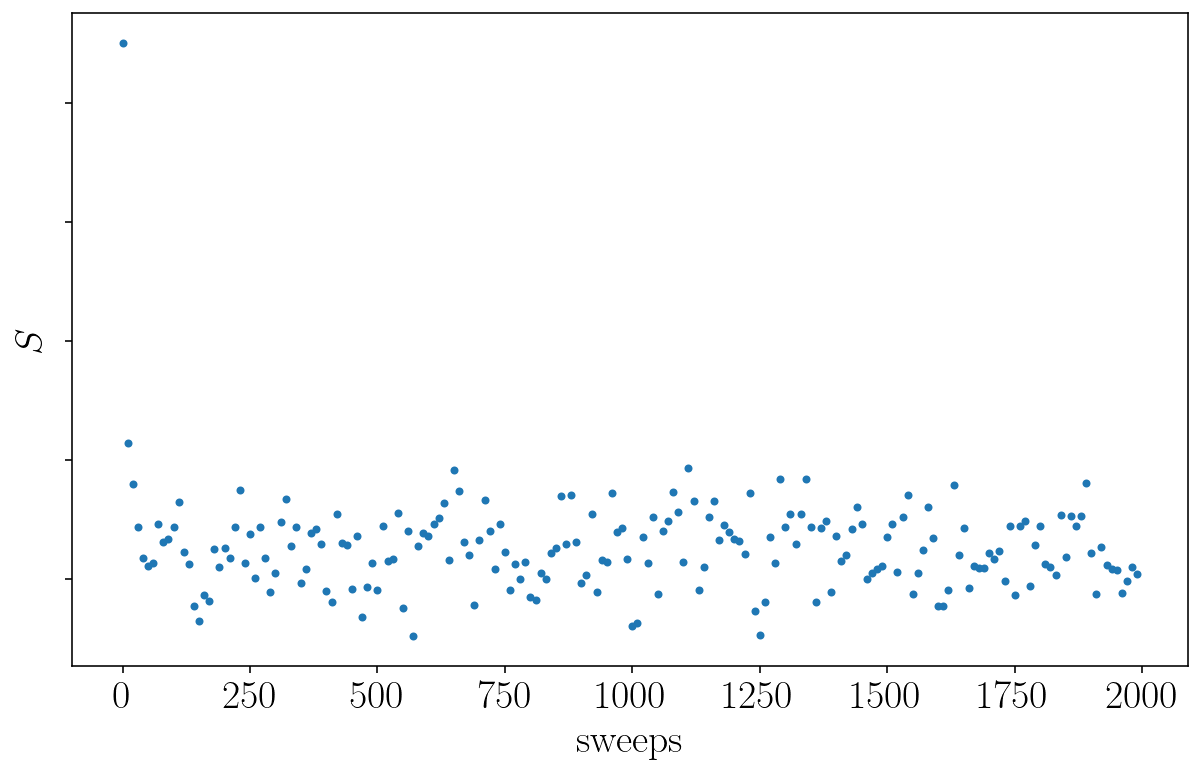

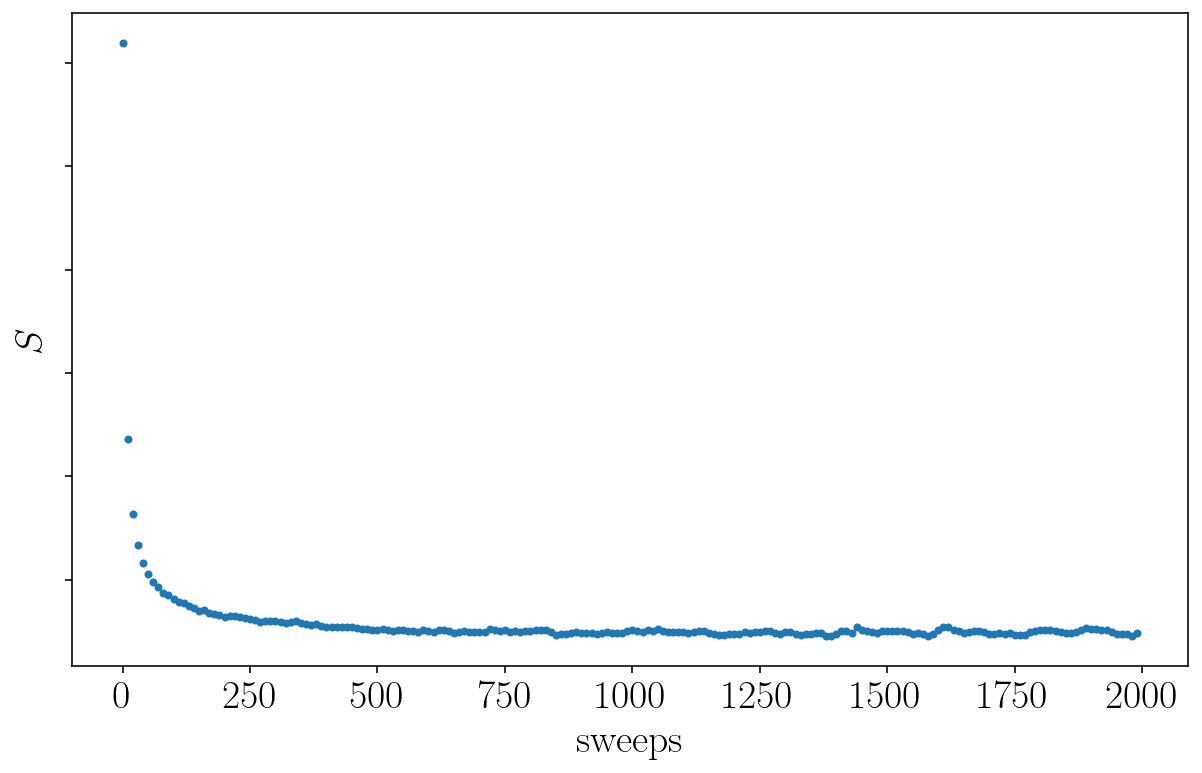

In [159]:
data = get_data("data_therm")
for L in data.L.unique():
    trial = data[data.L == L]
    plt.figure(figsize=(10,6))
    plt.plot(np.arange(200)*10, trial.S,'.')
    plt.gca().set_yticklabels([])
    plt.ylabel(r"$S$")
    plt.xlabel(r"$\mathrm{sweeps}$")
    plt.show()
    
    

(0.0, 95.55)

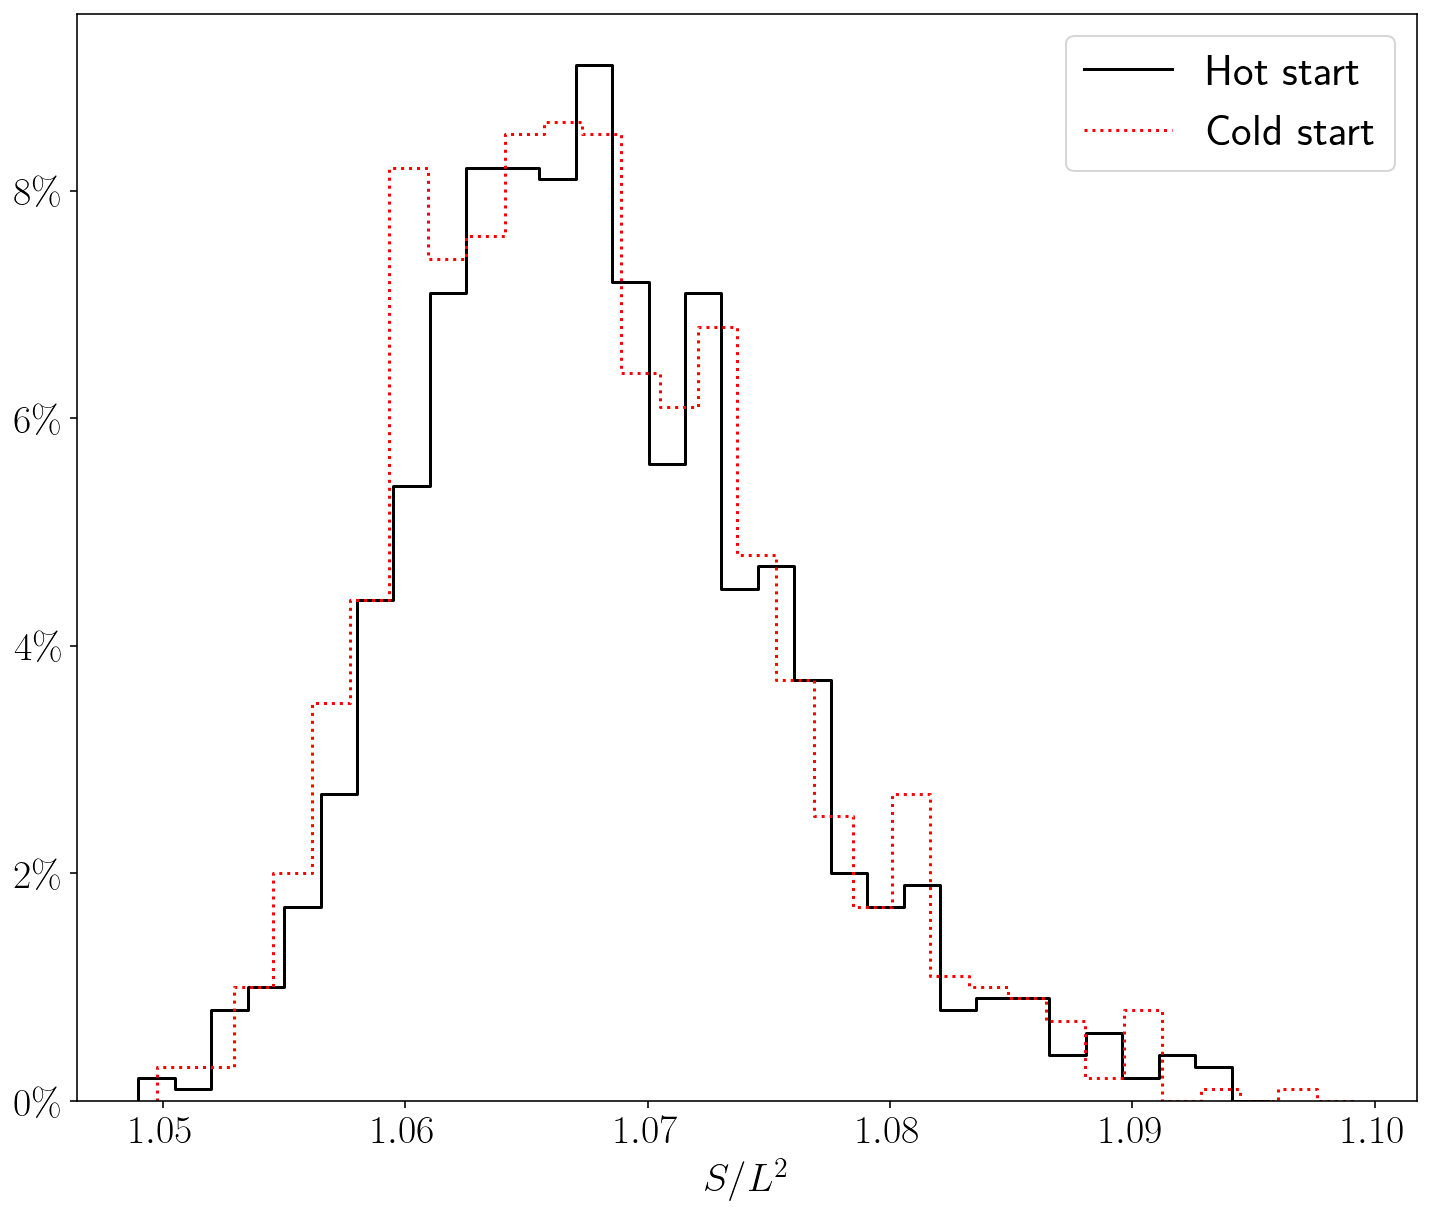

In [25]:
def histOutline(dataIn, *args, **kwargs):
    (histIn, binsIn) = np.histogram(dataIn, *args, **kwargs)

    stepSize = binsIn[1] - binsIn[0]

    bins = np.zeros(len(binsIn)*2 + 2, dtype=float)
    data = np.zeros(len(binsIn)*2 + 2, dtype=float)
    for bb in range(len(binsIn)):
        bins[2*bb + 1] = binsIn[bb]
        bins[2*bb + 2] = binsIn[bb] + stepSize
        if bb < len(histIn):
            data[2*bb + 1] = histIn[bb]
            data[2*bb + 2] = histIn[bb]

    bins[0] = bins[1]
    bins[-1] = bins[-2]
    data[0] = 0
    data[-1] = 0

    return (bins, data)

hotdata = get_data('hotstart404')
colddata = get_data('coldstart404')

num_bins = 30

plt.figure(figsize=(12,10))

L = 404

(bins, n) = histOutline(hotdata.S.to_numpy()[1:]/L**2, bins=num_bins)
plt.plot(bins, n, 'k-', label='Hot start')

(bins, n) = histOutline(colddata.S.to_numpy()[1:]/L**2, bins=num_bins)
plt.plot(bins, n, 'r:', label='Cold start')

plt.xlabel("$S/L^2$")

def formatter(x,y):
    return f"${int(x / hotdata.S.size * 100)}\%$"
plt.gca().yaxis.set_major_formatter(formatter)
plt.gca().xaxis.set_minor_locator(MultipleLocator(1))

plt.legend()
plt.ylim((0., None))


# Berg & Luscher

internal_energy
chi_m


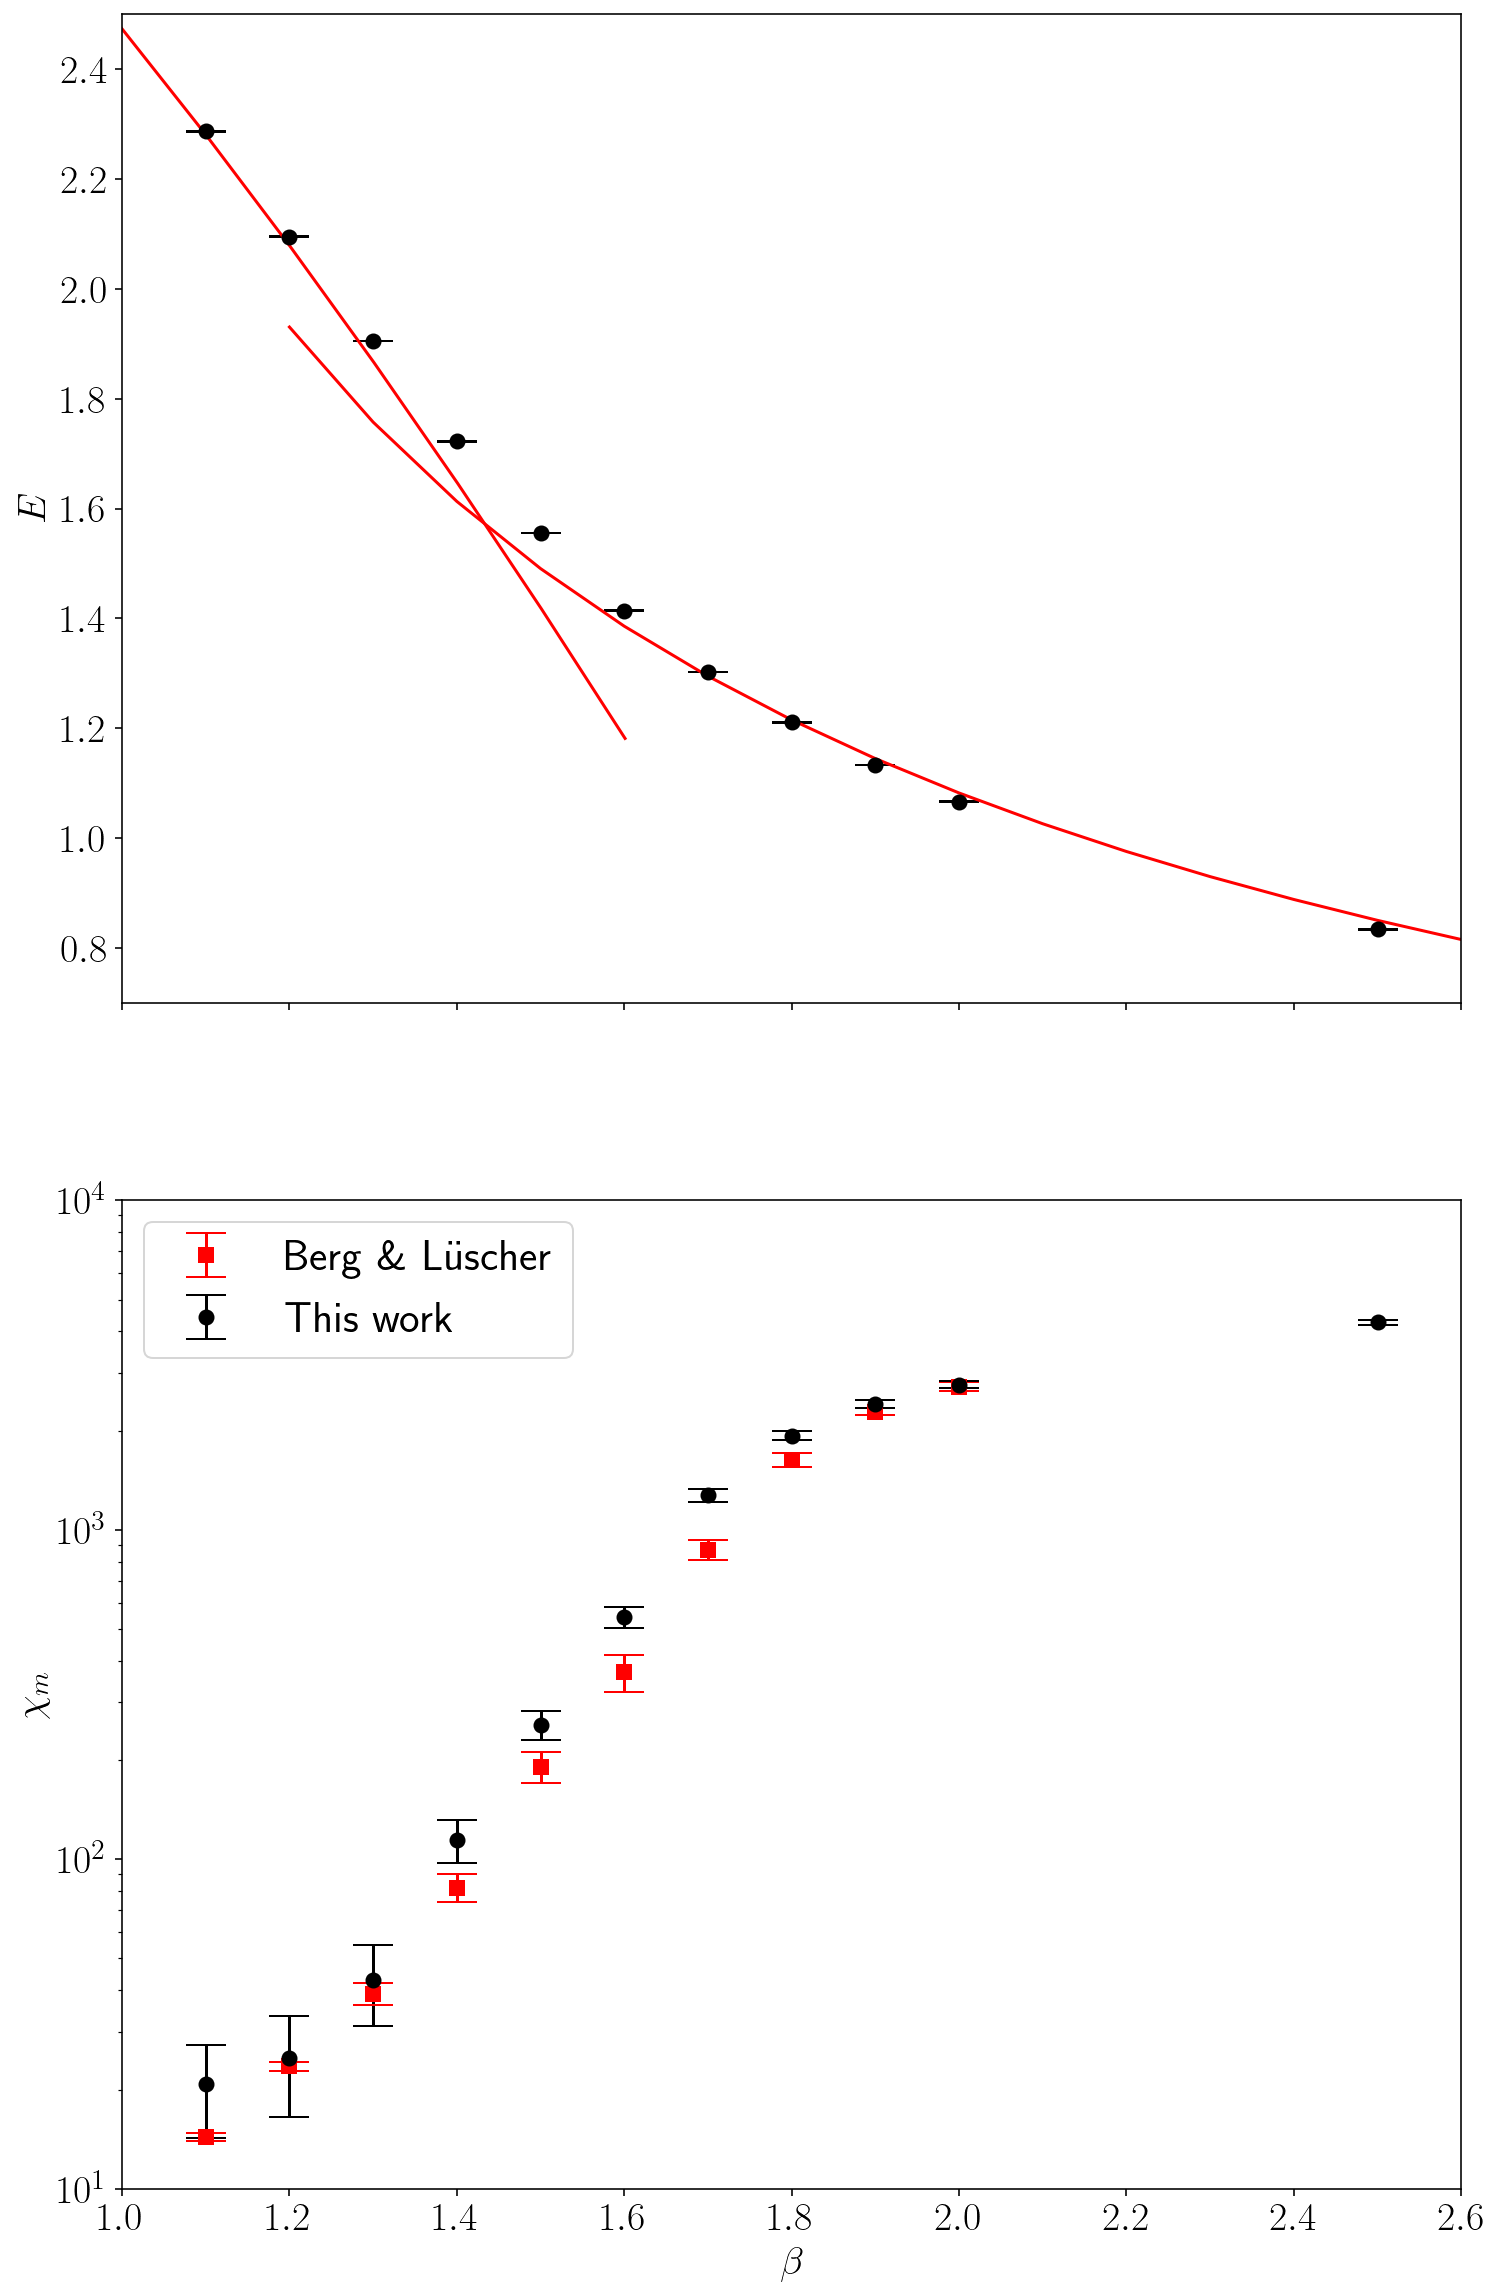

In [43]:
import csv

betas = [1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.5]
orig_betas = [1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]

def o_filename(beta): return f"outputs/bergluscher2/params{beta:.1f}..csv"
o_filenames = [o_filename(beta) for beta in betas]

def parse_file(beta):
    return pd.read_csv(o_filename(beta))


chi_m_theory = [
        gvar(14.4, 0.4),
        gvar(23.5, 0.8),
        gvar(39, 3),
        gvar(82,8),
        gvar(191,21),
        gvar(370,48),
        gvar(871, 61),
        gvar(1634, 82),
        gvar(2285,58),
        gvar(2720,85)
    ]

chi_m_betas = [1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]


observ_names = ["internal_energy", "chi_m"]
observ_objs = {o:global_observables[o] for o in observ_names}

fig,axes = plt.subplots(len(observ_names),1,figsize=(12,20), sharex=True, squeeze=False)
axes = [ax for row in axes for ax in row] # flatten axes


#axes[0].set_title(f"L={L}, {measurements} measurements every {record_rate} sweeps, {thermalization} thermalization")

axes[1].set_xlabel(r"$\beta$")

plot_data = {k:[] for k in observ_objs.keys()}
for beta, of in zip(betas, o_filenames):
    data = parse_file(beta)
    for name,O in observ_objs.items():
        plot_data[name].append( O(data) )

for ax, name in zip(axes, observ_names):
    d = plot_data[name]
    O = observ_objs[name]
    if name=="chi_m":
        ax.errorbar(chi_m_betas, [x.mean for x in chi_m_theory], yerr=[x.sdev for x in chi_m_theory], label="Berg \& Lüscher", fmt='s',c='red',ms=7., capsize=10.)
    print(name)
    ax.errorbar(betas, [x.mean for x in d], yerr=[x.sdev for x in d], fmt='ko', label="This work", ms=7.,capsize=10.)

    ax.set_ylabel('$'+O.label+'$')
    ax.set_yscale(O.scale)

    ax.set_xlim((1.0, 2.6))

axes[1].legend()
axes[0].set_ylim((0.7,2.5))
axes[1].set_ylim((10,10**4))

# Theoretical values
beta_weak = np.arange(0.001,1.7, 0.1)
beta_strong = np.arange(1.2, 3.4, 0.1)

y = np.cosh(beta_weak)/np.sinh(beta_weak) - 1/beta_weak
Eweak = 4 - 4*y - 8 * y**3 - 48/5 * y**5

Estrong = 2/beta_strong + 1/(4*beta_strong**2) + 0.156/beta_strong**3

axes[0].plot(beta_weak, Eweak,'r-')
axes[0].plot(beta_strong, Estrong,'r-')

# axes[0].set_ylim((0., 4.))
plt.show()
# def read_data(beta):
# fname = o_filename(beta)
# with open(fname, 'r') as datafile:
    # csv_data = csv.reader(datafile)
    # for lines in csv_data:
        # data.append([float(l) for l in lines])
# return np.array(data).T




# $\theta \neq 0$

0
1
6


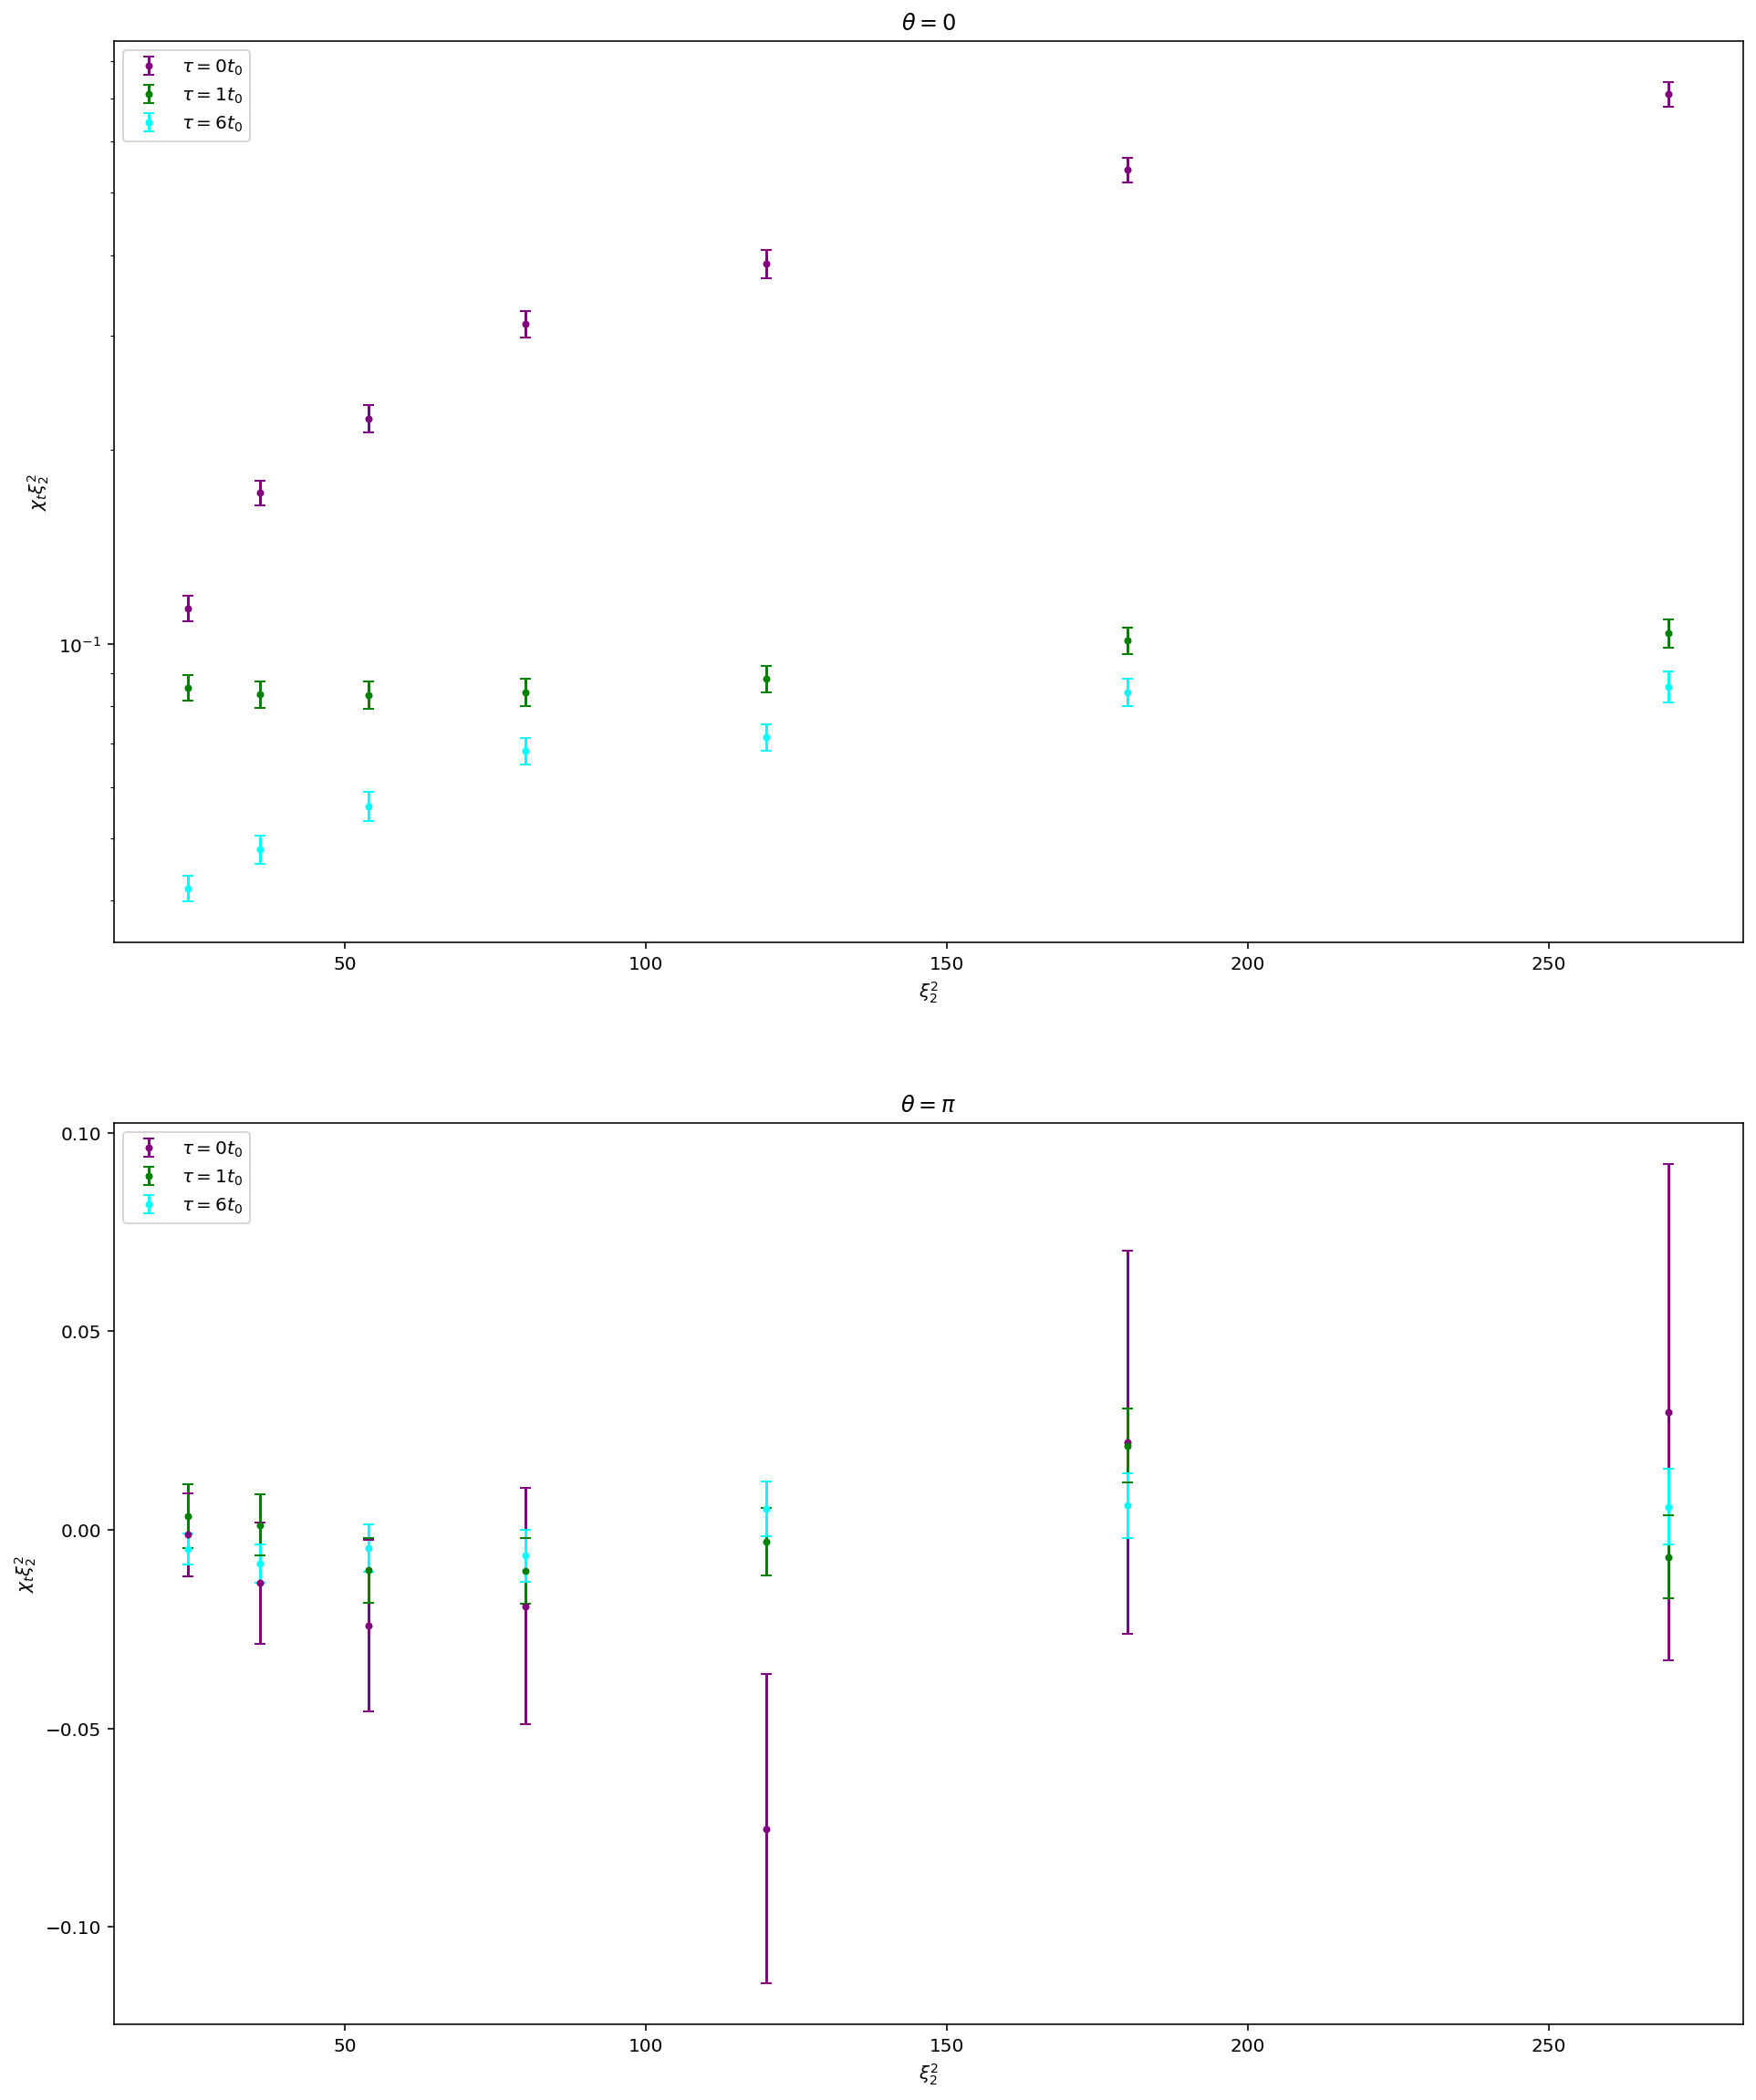

In [109]:
data = get_data()

fig,axes = plt.subplots(2,1,figsize=(16,20))

O = global_observables['chi_t']

plot_taus = [0,1,6]
#plot_taus = [0,1,2,4,6,8,10]
plot_colors = ['purple', 'green', 'cyan', 'orange', 'blue', 'red', 'black']

for i,tau in enumerate(plot_taus):
    print(tau)
    dtriv = []
    dtopo = []

    Ls = []
    for j,p in bietenholz_params.iterrows():
        trial = data[(round(data['tau'],10) == round(tau*p.t0,10)) & (data['L'] == p.L)]
        if trial.size == 0: continue
            
        Ls.append(p.L)
        dtriv.append(O(trial) / p.L**2 * p.xi2**2)
        
        dtopo.append( (O(trial[trial.Q%2==0]) - O(trial[trial.Q%2==1])) / p.L**2 * p.xi2**2)

    axes[0].errorbar(Ls, [x.mean for x in dtriv], yerr=[x.sdev for x in dtriv], fmt='.', c=plot_colors[i], label=f"$\\tau={tau}t_0$", capsize=3.)
    axes[1].errorbar(Ls, [x.mean for x in dtopo], yerr=[x.sdev for x in dtopo], fmt='.', c=plot_colors[i], label=f"$\\tau={tau}t_0$", capsize=3.)


axes[0].set_title(r"$\theta=0$")
axes[1].set_title(r"$\theta=\pi$")
axes[0].set_yscale(O.scale)
for ax in axes:
    ax.legend()
    ax.set_ylabel(r"$\chi_t \xi_2^2$");
    ax.set_xlabel(r"$\xi_2^2$")

plt.show()

0
1
6


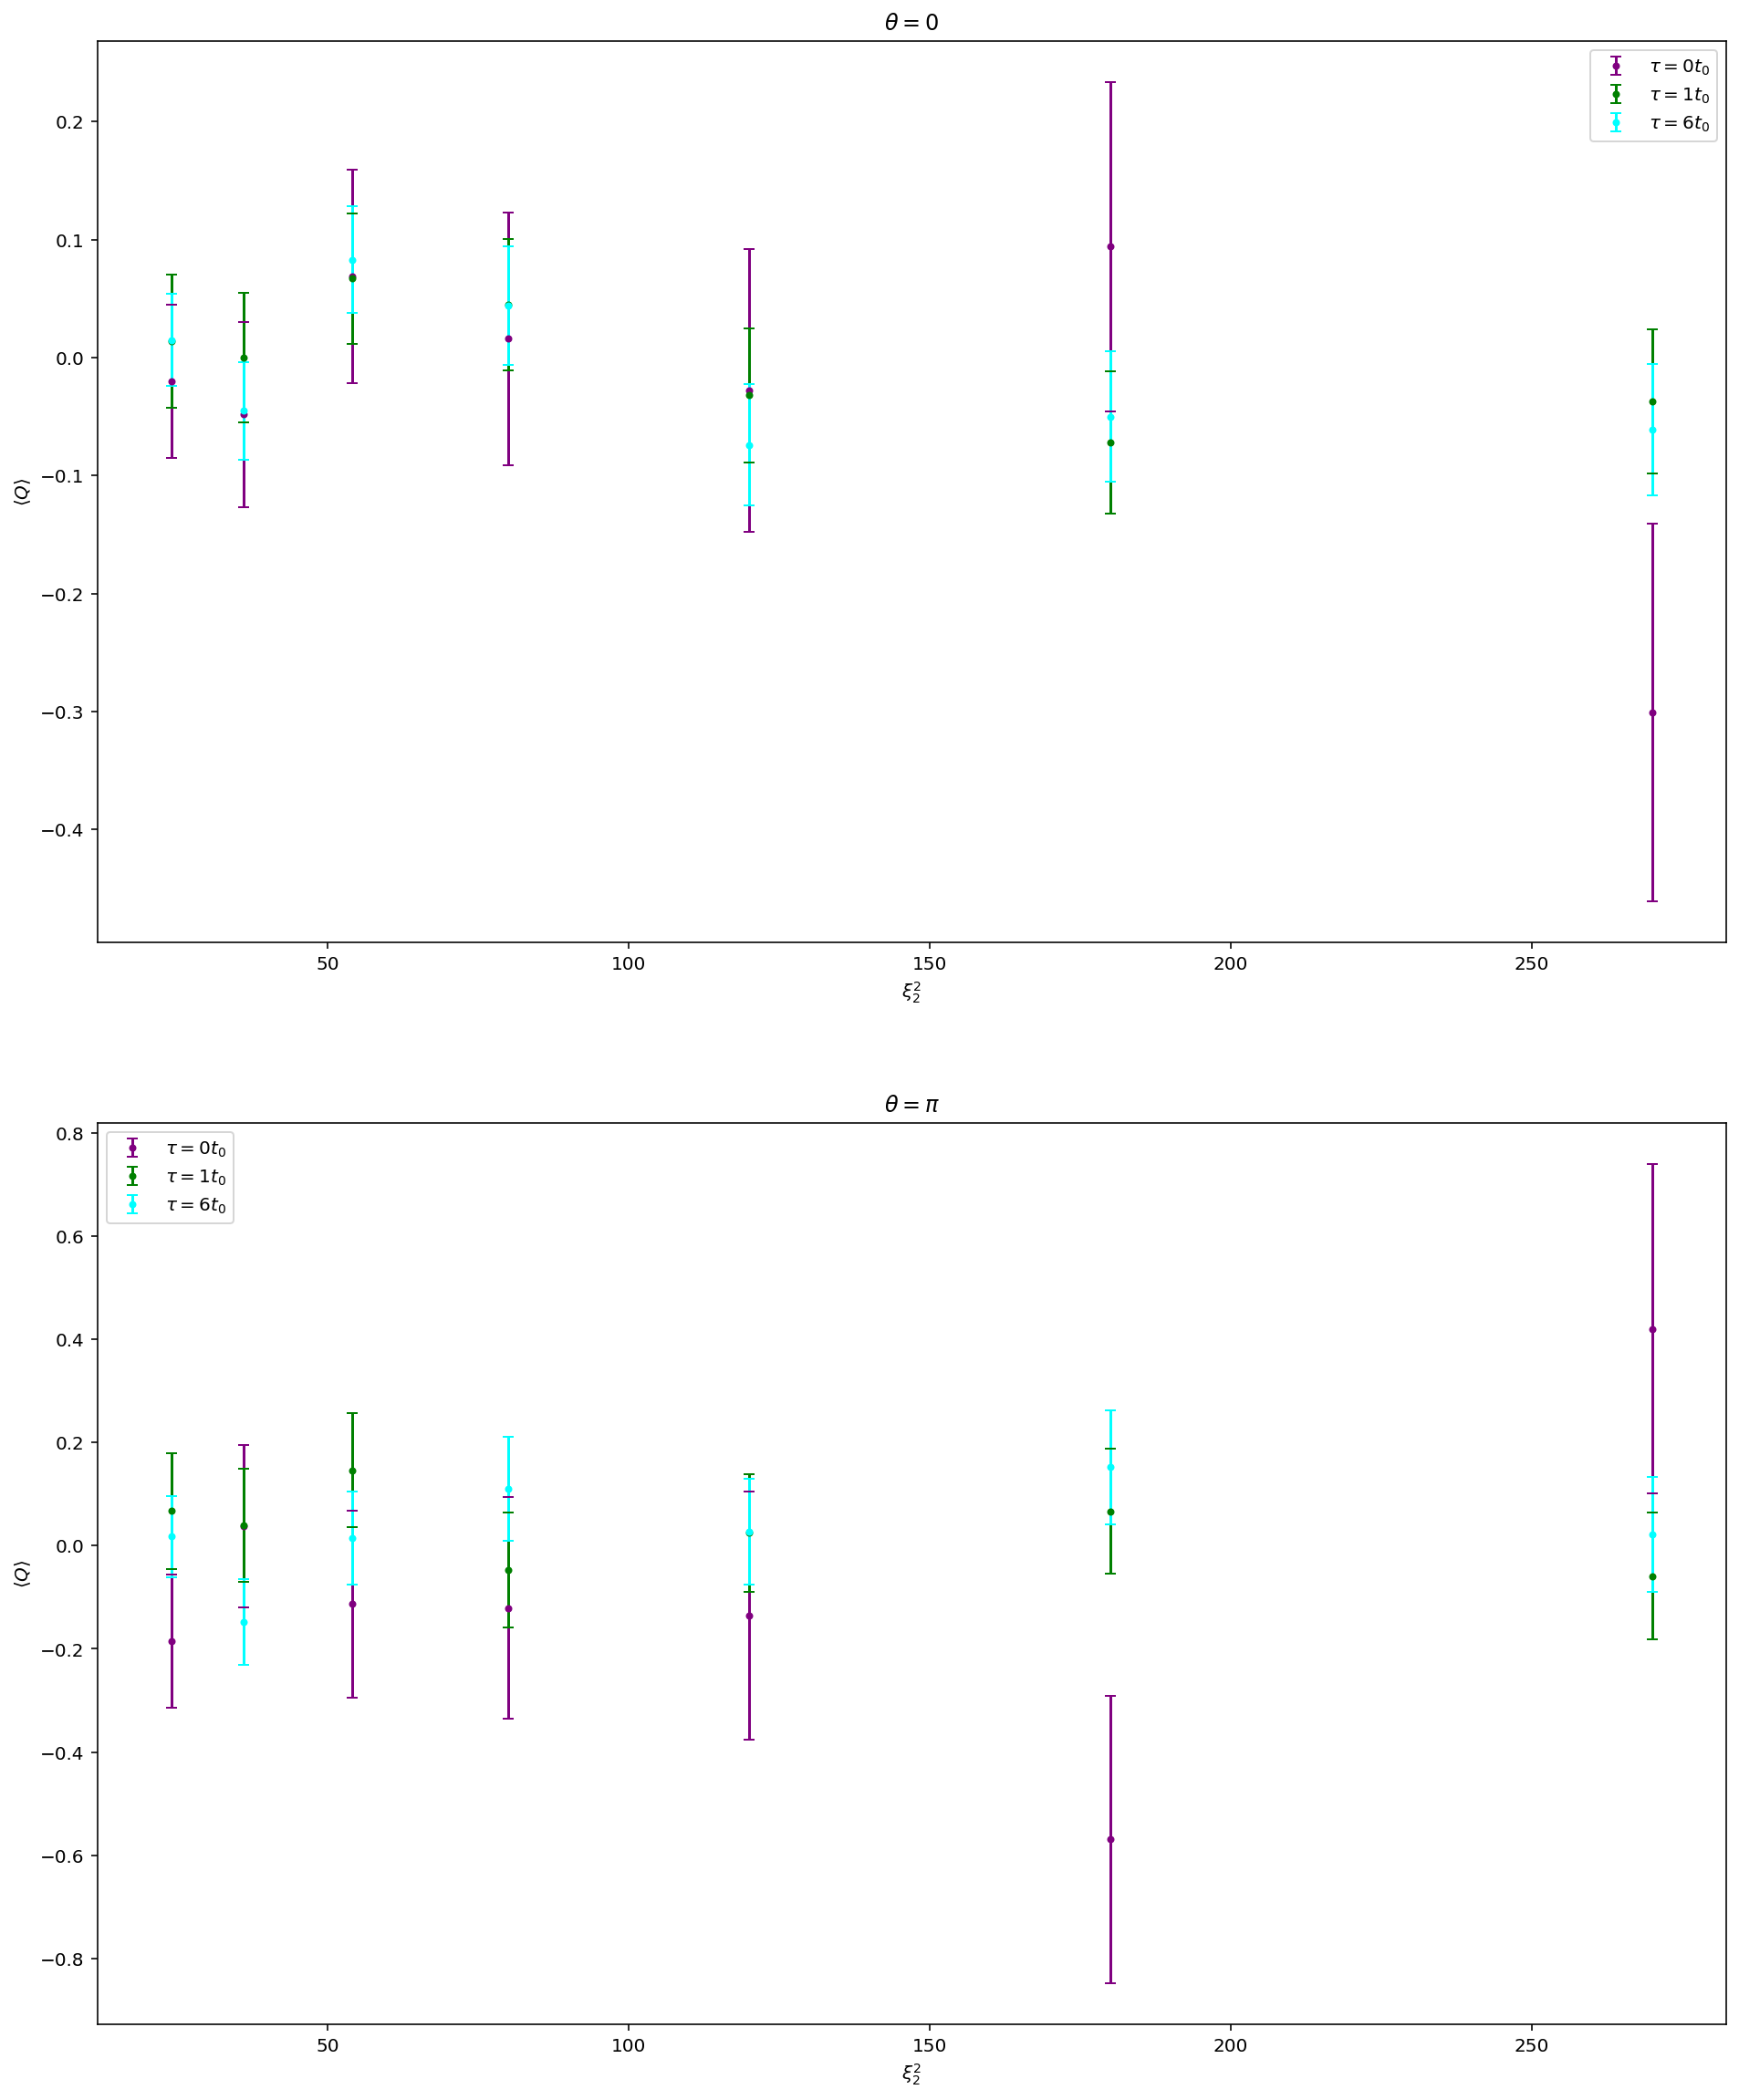

In [110]:
data = get_data()

fig,axes = plt.subplots(2,1,figsize=(16,20))

O = global_observables['Q']

plot_taus = [0,1,6]
#plot_taus = [0,1,2,4,6,8,10]
plot_colors = ['purple', 'green', 'cyan', 'orange', 'blue', 'red', 'black']

for i,tau in enumerate(plot_taus):
    print(tau)
    dtriv = []
    dtopo = []

    Ls = []
    for j,p in bietenholz_params.iterrows():
        trial = data[(round(data['tau'],10) == round(tau*p.t0,10)) & (data['L'] == p.L)]
        if trial.size == 0: continue
            
        Ls.append(p.L)
        dtriv.append(O(trial))
        
        dtopo.append( O(trial[trial.Q%2==0]) - O(trial[trial.Q%2==1]) )

    axes[0].errorbar(Ls, [x.mean for x in dtriv], yerr=[x.sdev for x in dtriv], fmt='.', c=plot_colors[i], label=f"$\\tau={tau}t_0$", capsize=3.)
    axes[1].errorbar(Ls, [x.mean for x in dtopo], yerr=[x.sdev for x in dtopo], fmt='.', c=plot_colors[i], label=f"$\\tau={tau}t_0$", capsize=3.)


axes[0].set_title(r"$\theta=0$")
axes[1].set_title(r"$\theta=\pi$")
axes[0].set_yscale(O.scale)
for ax in axes:
    ax.legend()
    ax.set_ylabel(r"$\langle Q \rangle$");
    ax.set_xlabel(r"$\xi_2^2$")

plt.show()

In [ ]:
from scipy.misc import derivative
from scipy.optimize import curve_fit
from functools import partial
thetas = [-0.1, 0.1] #np.linspace(-np.pi,np.pi,200)


data = get_data()

xi2s = bietenholz_params.xi2.to_numpy()
y = np.zeros_like(xi2s)
plt.figure(figsize=(16,10))

for tau in taus[::2]:
    for i,p in bietenholz_params.iterrows():
        chi = derivative(partial(get_iQ,L=p.L,tau=tau*p.t0), 0., dx=0.01)        
        y[i] = chi #/ L**2 * xi2**2
        
    plt.plot(xi2s, y, '*', label=f"$\\tau={tau}t_0$")
    plt.ylabel(r"$\chi_t \xi_2^2$");
    plt.xlabel(r"$\xi_2^2$")
    plt.legend()

In [159]:
bietenholz_params

,L,beta,t0,xi2,xi2_err
0,24,1.263,0.100,3.96,0.01
1,36,1.370,0.225,6.01,0.01
2,54,1.458,0.506,8.93,0.04
3,80,1.535,1.111,13.24,0.04
4,120,1.607,2.500,19.77,0.11
5,180,1.677,5.625,30.01,0.18
6,270,1.743,12.656,44.97,0.24
7,404,1.807,28.336,67.66,0.31


In [168]:
chi_t.sdev

0.00758(11)

In [174]:
global_observables['chi_t']()

Text(0.5, 0, '$L$')

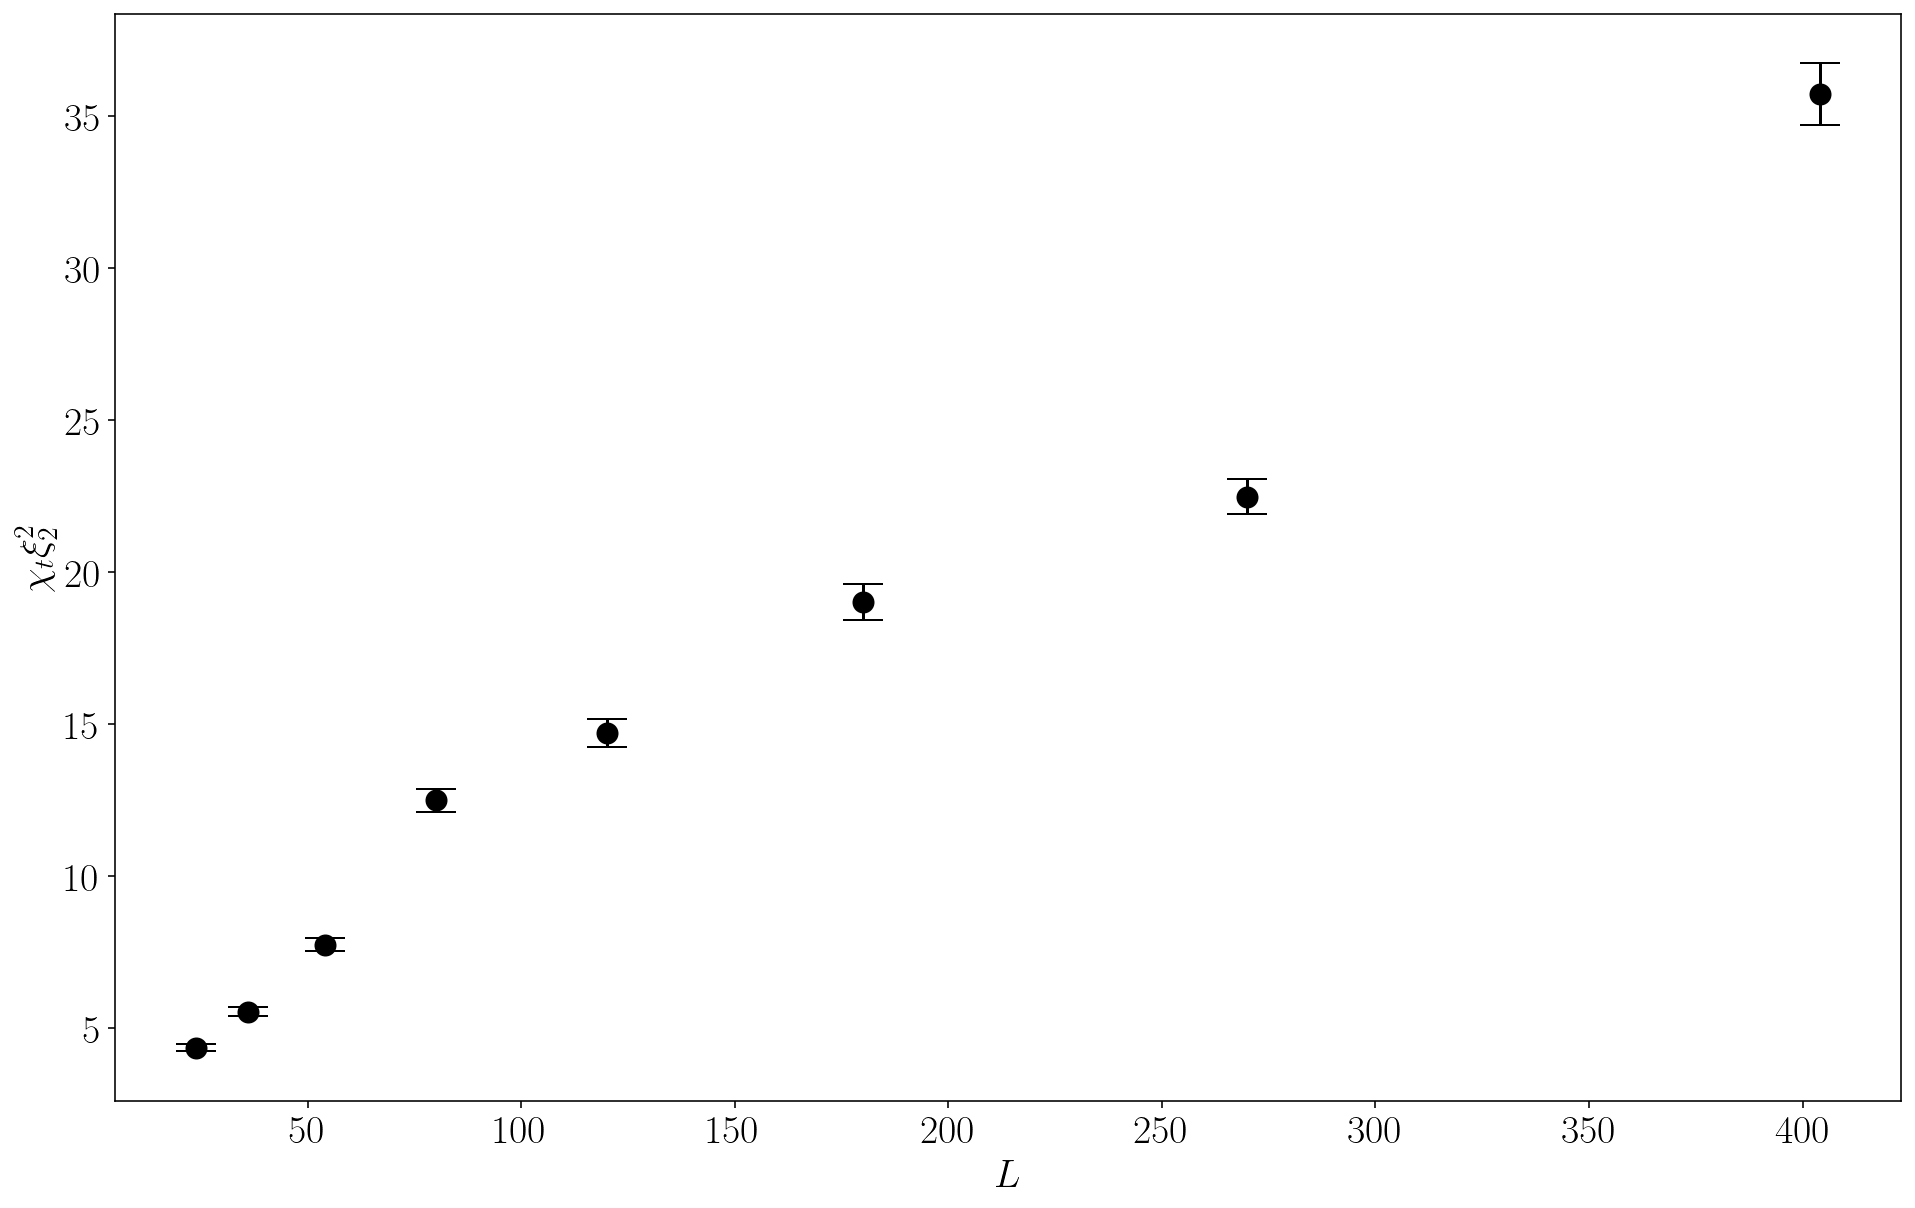

In [180]:
from scipy.optimize import curve_fit
data = get_data("data5")
xi2s = bietenholz_params.xi2.to_numpy()
Ls = bietenholz_params.L.to_numpy()
y = np.zeros_like(xi2s)
yerr = np.zeros_like(xi2s)
plt.figure(figsize=(16,10))

tau = 0.
trial = data
for i,p in bietenholz_params.iterrows():
    trial = data[(data.L == p.L) & (np.abs(data.tau - tau*p.t0)<0.001)]
    
    N = len(trial)
    
    chi_t = gvar( (trial.Q**2).mean(), (trial.Q**2).std() )
    y[i] = chi_t.mean
    yerr[i] = 2*chi_t.sdev / np.sqrt(N)

plt.errorbar(Ls, y, yerr=yerr, fmt='ko', capsize=10, ms=10, label=f"Monte Carlo")
plt.ylabel(r"$\chi_t \xi_2^2$");
#plt.xlabel(r"$\xi_2^2$")
plt.xlabel(r"$L$")

In [241]:
data = get_data('data_bugtest')

,tau,beta,L,S,Q,chi_m,F
12000,0.0,1.263,24,714.372,-1,NaN,NaN
12011,0.0,1.263,24,758.028,-1,NaN,NaN
12022,0.0,1.263,24,735.606,1,NaN,NaN
12033,0.0,1.263,24,705.107,2,NaN,NaN
12044,0.0,1.263,24,751.001,2,NaN,NaN
...,...,...,...,...,...,...,...
133995,0.0,1.807,24,632.900,0,NaN,NaN
133996,0.0,1.807,24,711.277,1,NaN,NaN
133997,0.0,1.807,24,600.194,0,NaN,NaN
133998,0.0,1.807,24,589.306,0,NaN,NaN


popt: [0.91575286 0.0253543  1.03987278]
27.788508931626595 5 5.557701786325319

popt: [ 0.05193366  0.69199277 -0.01631165]
9.05884064205907 5 1.8117681284118141
[1.87740534e-05 3.84008403e-04 7.41270973e-05]


<ipython-input-53-f8addc621042>:34: RuntimeWarning: invalid value encountered in log
  return A*np.log(B*x + C)
<ipython-input-53-f8addc621042>:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([f"${int(L)}$" for L in Ls])


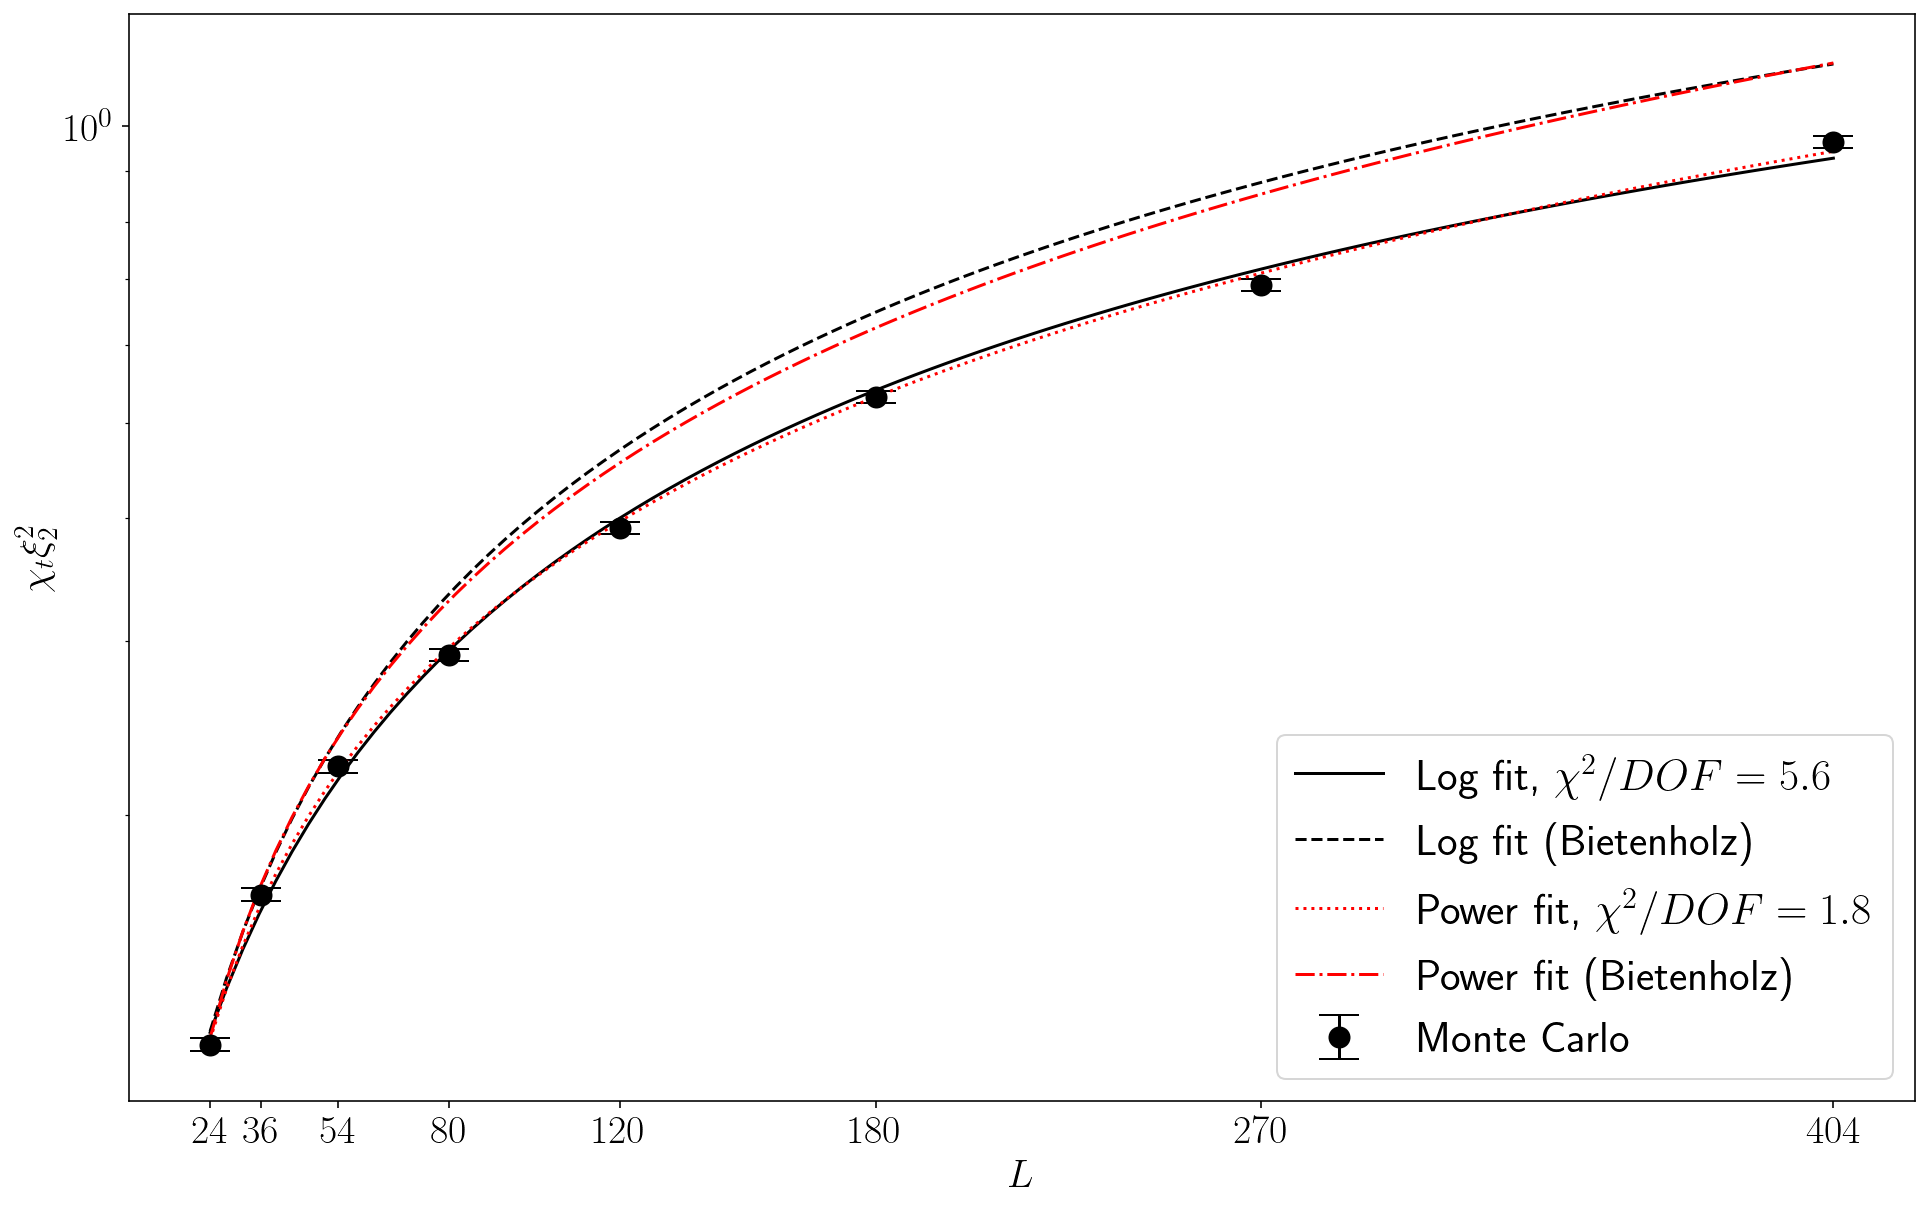

In [53]:
from scipy.optimize import curve_fit
data = get_data("data5_fixed")
xi2s = bietenholz_params.xi2.to_numpy()
Ls = bietenholz_params.L.to_numpy()
y = np.zeros_like(xi2s)
yerr = np.zeros_like(xi2s)
plt.figure(figsize=(16,10))

tau = 0.
trial = data

cap = 0
for i,p in bietenholz_params.iterrows():
    trial = data[(data.L == p.L) & (np.abs(data.tau - tau*p.t0)<0.001)]

    N = len(trial)
    if N==0: 
        continue
    else:
        cap += 1
    
    chi_t = gvar( (trial.Q**2).mean(), (trial.Q**2).std() ) / p.L**2
    xi2 = gvar(p.xi2, p.xi2_err)
    y[i] = (chi_t * xi2**2).mean  
    yerr[i] = (chi_t * xi2**2).sdev/np.sqrt(N)

plt.errorbar(Ls, y, yerr=yerr, fmt='ko', capsize=10, ms=10, label=f"Monte Carlo")
plt.ylabel(r"$\chi_t \xi_2^2$");
#plt.xlabel(r"$\xi_2^2$")
plt.xlabel(r"$L$")

    
def fitlog(x,A,B,C):
    return A*np.log(B*x + C)

def fitpow(x,A,B,C):
    return A*(x**B)+C

def fitlin(x,A,C):
    return A*x+C

fit_L   = np.linspace(np.amin(Ls), np.amax(Ls), 100)
fit_xi2 = np.linspace(np.amin(xi2s), np.amax(xi2s), 100)

popt, pcov = curve_fit(fitlog, xi2s[:cap], y[:cap], p0=(1, 1, 0), sigma=yerr[:cap], absolute_sigma = True)
yexp = fitlog(xi2s, *popt)
r = y - yexp
chisq = np.sum(((r/yerr)**2)[:cap])
df = cap - 3
print("popt:",popt)
print(chisq,df,chisq/df)
plt.plot(fit_L, fitlog(fit_xi2, *popt), 'k-', label=f"Log fit, \t$\\chi^2/DOF={chisq/df:.1f}$")

plt.plot(fit_L, fitlog(fit_xi2, 1.3, 0.021, 1.014), 'k--', label=f"Log fit (Bietenholz)")

print()

popt, pcov = curve_fit(fitpow, xi2s[:cap], y[:cap], p0=(1, 1, 0), sigma=yerr[:cap], absolute_sigma = True)
yexp = fitpow(xi2s, *popt)
r = y - yexp
chisq = np.sum(((r/yerr)**2)[:cap])
df = cap - 3
print("popt:",popt)
print(chisq,df,chisq/df)
plt.plot(fit_L, fitpow(fit_xi2, *popt), color='red', ls=':', label=f"Power fit, \t$\\chi^2/DOF={chisq/df:.1f}$")

plt.plot(fit_L, fitpow(fit_xi2, 0.0522, 0.741, -0.026), color='red', ls='-.', label=f"Power fit (Bietenholz)")


plt.legend()

plt.gca().set_xticklabels([f"${int(L)}$" for L in Ls])
plt.gca().set_xticks(Ls)
plt.yscale('log')
#plt.ylim((0.1,1.3))


    
print(np.diagonal(pcov))
    

popt: [0.02503138 0.7995169  2.69133925]
36.94863898415285 5 7.38972779683057

popt: [ 0.07186576  0.17199299 -0.0471551 ]
43.77298204822611 5 8.754596409645222
[0.00123034 0.00335177 0.00141091]


<ipython-input-61-41f59888f672>:70: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([f"${int(L)}$" for L in Ls])


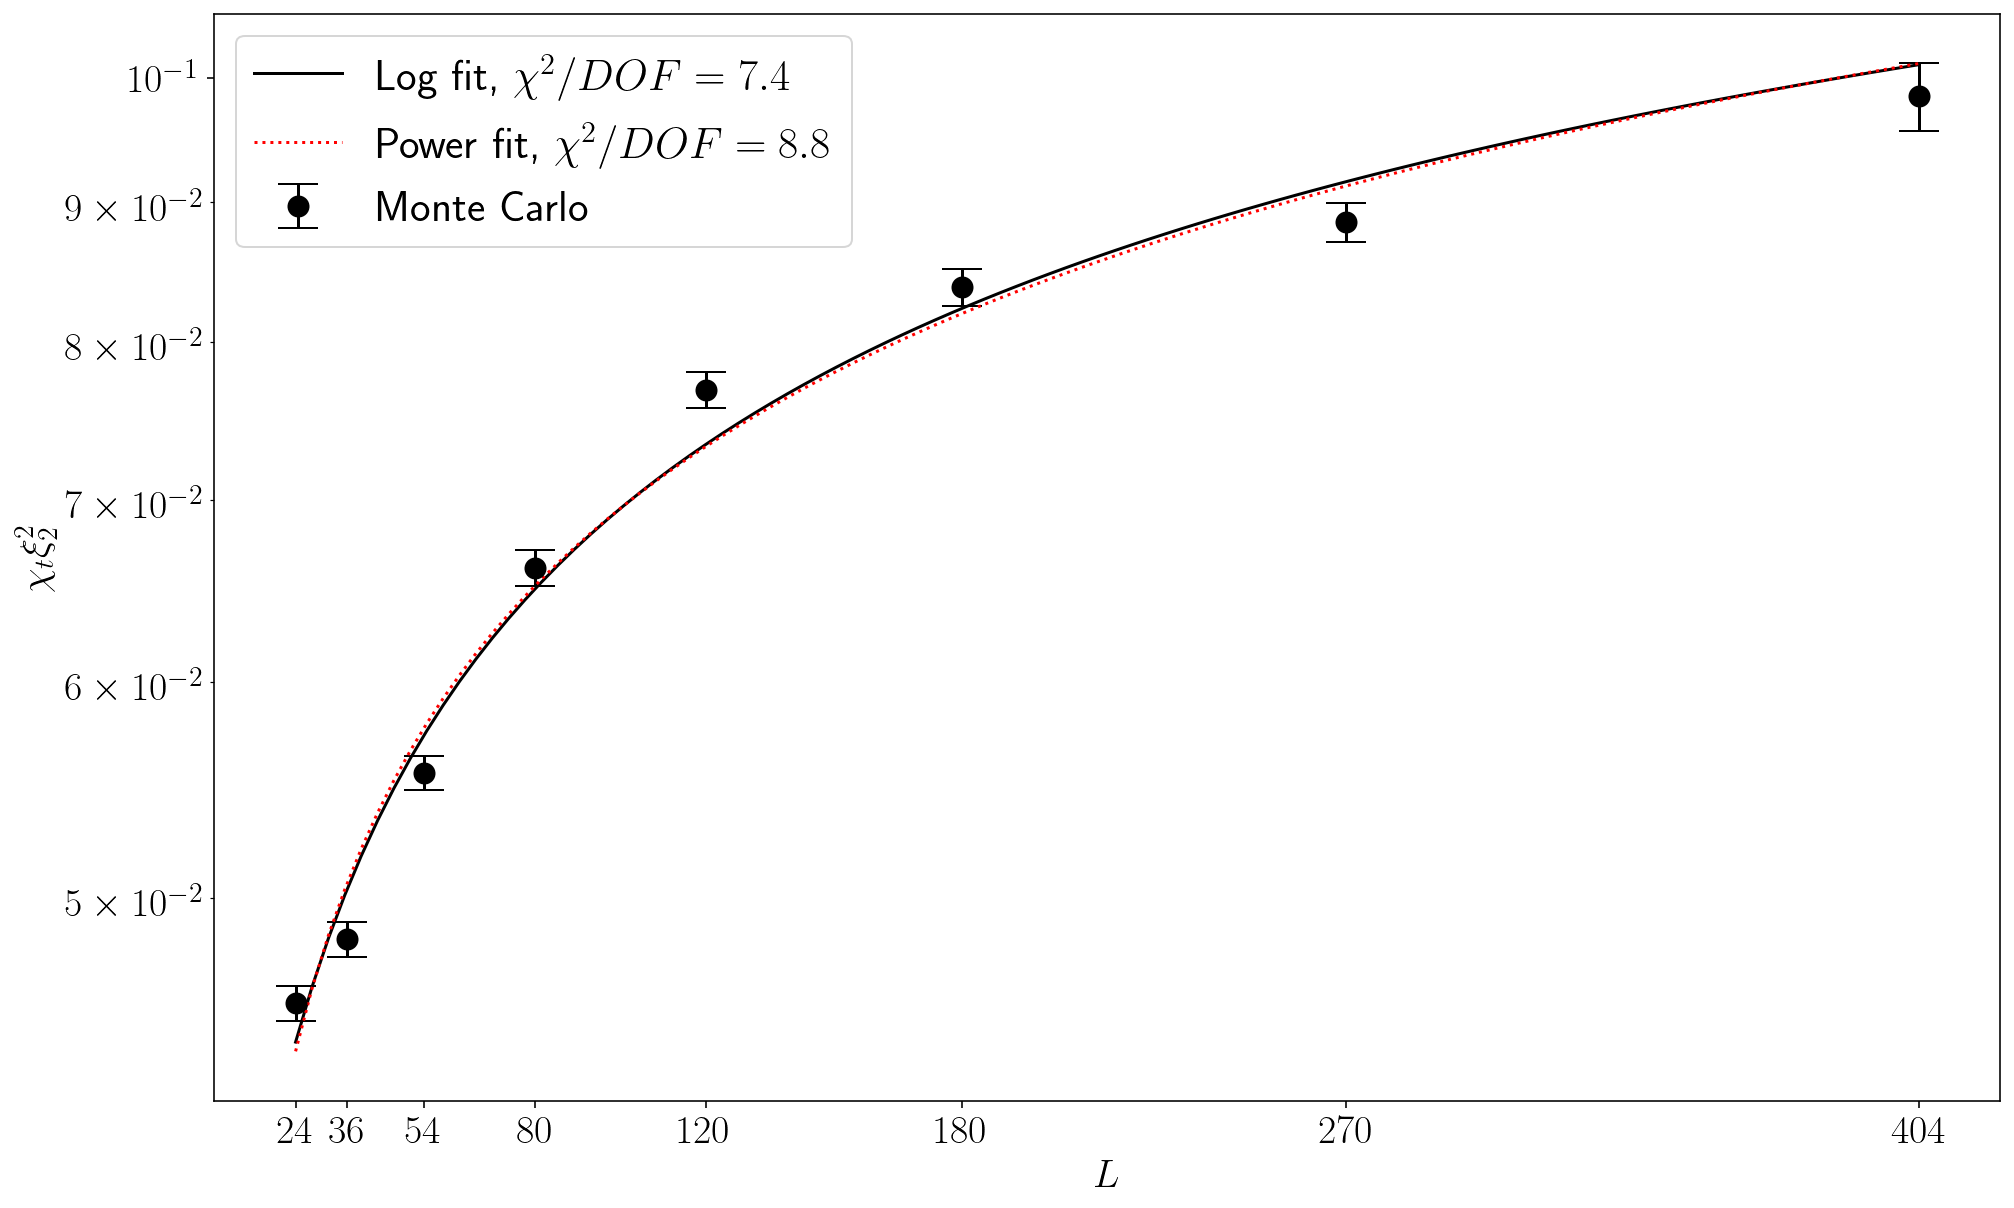

In [61]:
from scipy.optimize import curve_fit
data = get_data("data5_fixed")
xi2s = bietenholz_params.xi2.to_numpy()
Ls = bietenholz_params.L.to_numpy()
y = np.zeros_like(xi2s)
yerr = np.zeros_like(xi2s)
plt.figure(figsize=(16,10))

tau = 5.
trial = data

cap = 0
for i,p in bietenholz_params.iterrows():
    trial = data[(data.L == p.L) & (np.abs(data.tau - tau*p.t0)<0.001)]

    N = len(trial)
    if N==0: 
        continue
    else:
        cap += 1
    
    chi_t = gvar( (trial.Q**2).mean(), (trial.Q**2).std() ) / p.L**2
    xi2 = gvar(p.xi2, p.xi2_err)
    y[i] = (chi_t * xi2**2).mean  
    yerr[i] = (chi_t * xi2**2).sdev/np.sqrt(N)

plt.errorbar(Ls, y, yerr=yerr, fmt='ko', capsize=10, ms=10, label=f"Monte Carlo")
plt.ylabel(r"$\chi_t \xi_2^2$");
#plt.xlabel(r"$\xi_2^2$")
plt.xlabel(r"$L$")

    
def fitlog(x,A,B,C):
    return A*np.log(B*x + C)

def fitpow(x,A,B,C):
    return A*(x**B)+C

def fitlin(x,A,C):
    return A*x+C

fit_L   = np.linspace(np.amin(Ls), np.amax(Ls), 100)
fit_xi2 = np.linspace(np.amin(xi2s), np.amax(xi2s), 100)

popt, pcov = curve_fit(fitlog, xi2s[:cap], y[:cap], p0=(1, 1, 0), sigma=yerr[:cap], absolute_sigma = True)
yexp = fitlog(xi2s, *popt)
r = y - yexp
chisq = np.sum(((r/yerr)**2)[:cap])
df = cap - 3
print("popt:",popt)
print(chisq,df,chisq/df)
plt.plot(fit_L, fitlog(fit_xi2, *popt), 'k-', label=f"Log fit, \t$\\chi^2/DOF={chisq/df:.1f}$")


print()

popt, pcov = curve_fit(fitpow, xi2s[:cap], y[:cap], p0=(1, 1, 0), sigma=yerr[:cap], absolute_sigma = True)
yexp = fitpow(xi2s, *popt)
r = y - yexp
chisq = np.sum(((r/yerr)**2)[:cap])
df = cap - 3
print("popt:",popt)
print(chisq,df,chisq/df)
plt.plot(fit_L, fitpow(fit_xi2, *popt), color='red', ls=':', label=f"Power fit, \t$\\chi^2/DOF={chisq/df:.1f}$")



plt.legend()

plt.gca().set_xticklabels([f"${int(L)}$" for L in Ls])
plt.gca().set_xticks(Ls)
plt.yscale('log')
#plt.ylim((0.1,1.3))


    
print(np.diagonal(pcov))
    

# Expand series to arbitrary order

In [6]:
np.set_printoptions(precision=3,suppress=True)

[   -0.301    25.633   -28.531  1930.453 -4061.851]
[[    0.005    -0.004     0.384    -0.696    45.349]
 [   -0.004     0.255    -0.666    35.697  -122.69 ]
 [    0.384    -0.666    45.431  -132.498  5088.348]
 [   -0.696    35.697  -132.498  4366.196  -599.084]
 [   45.349  -122.69   5088.348  -599.084 16883.743]]


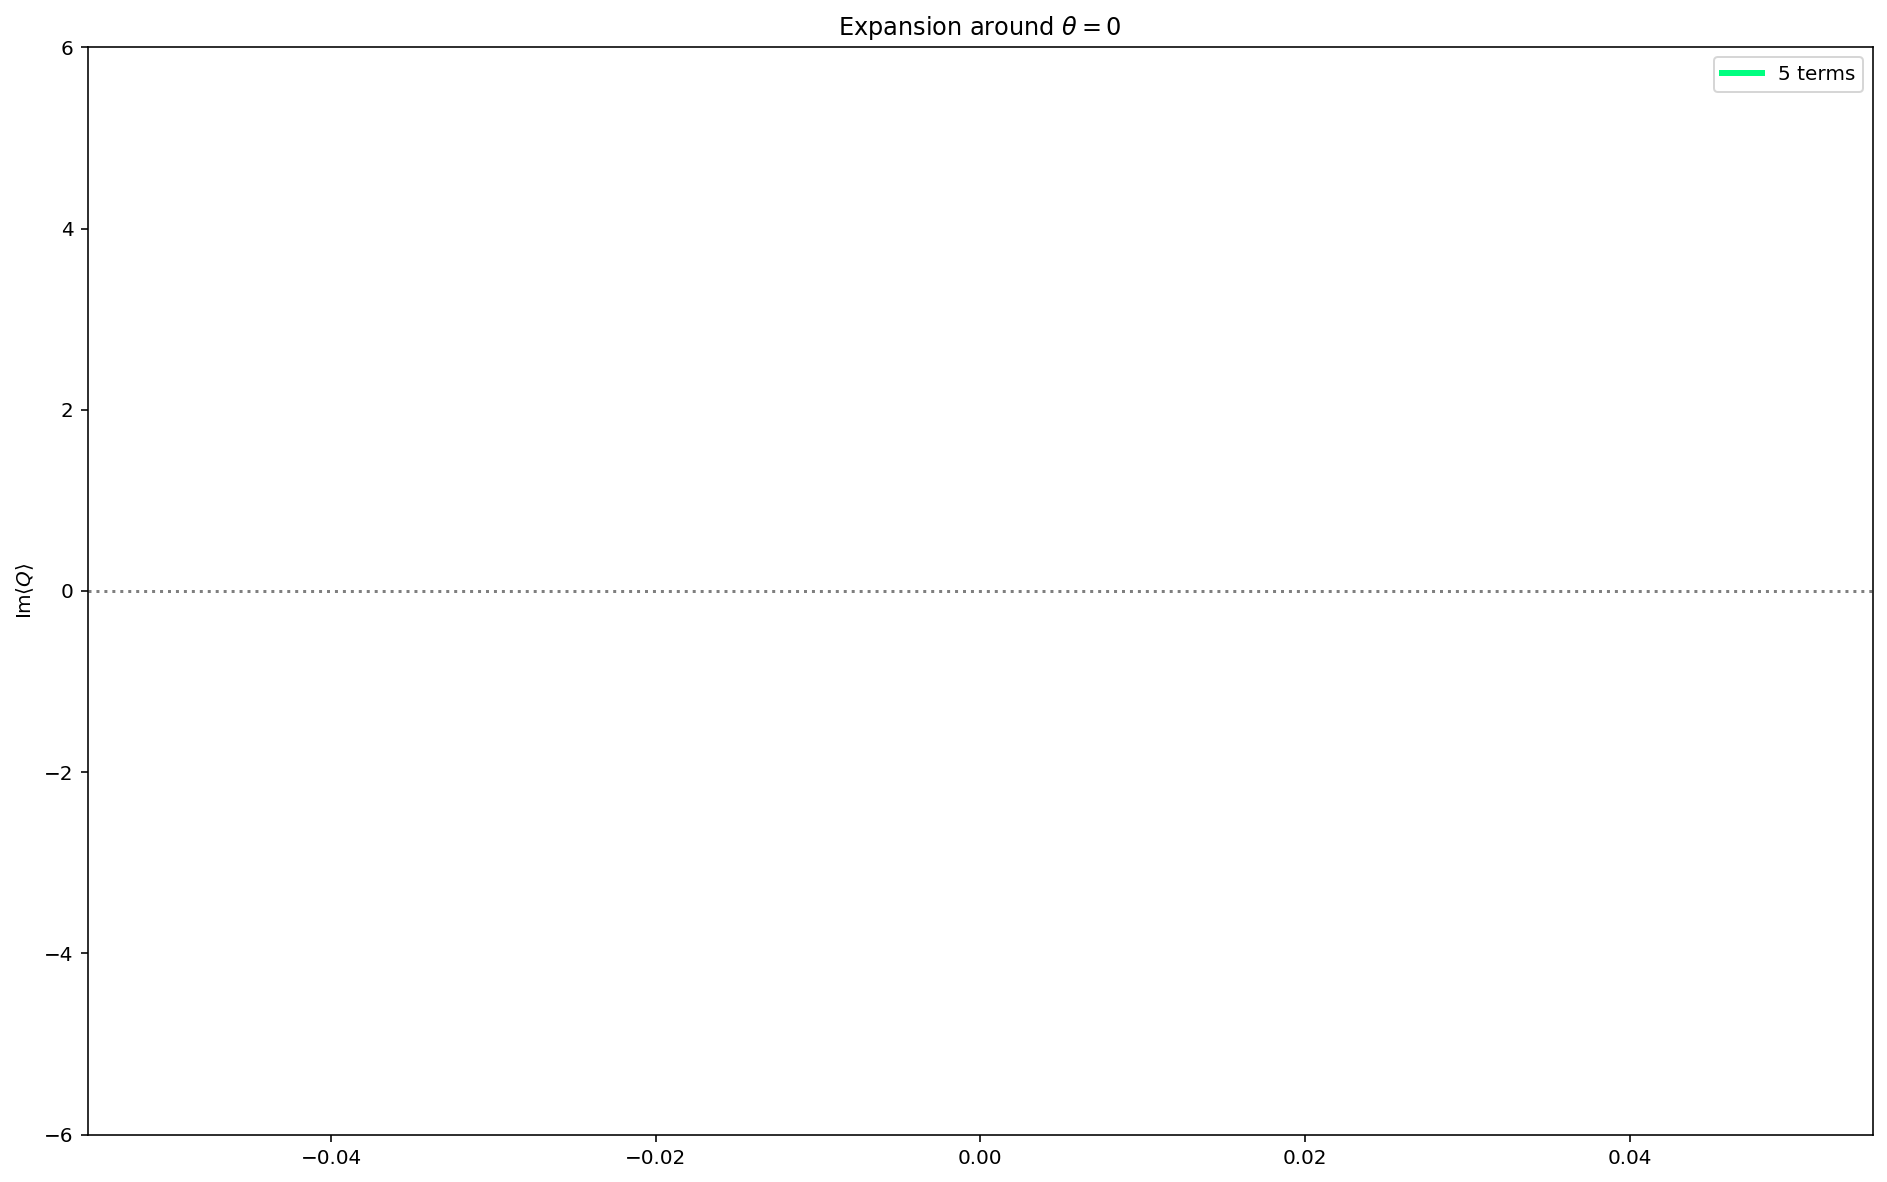

In [7]:
# effect of order



theta0 = 0
orders = [5]

data = get_data()
fig,axes = plt.subplots(1,1,figsize=(16,10),squeeze=False)
axes = axes[:,0]

if theta0 == 0.: theta0 = 2*np.pi
if 2*np.pi/theta0 != int(2*np.pi/theta0): raise Exception("Infinite topological sectors")
num_sectors = int(2*np.pi / theta0) # this is actually a signed value
thetas = [0.]#np.linspace(-1+theta0, 1+theta0, 101)

errQs = np.zeros_like(thetas)
Qs = np.zeros_like(thetas)

cs = cm.get_cmap('winter', len(orders))

for order in reversed(orders):
    for j,p in bietenholz_params.iterrows():
        if p.L != 270: continue
        trial = data[(round(data['tau'],10) == round(0.*p.t0,10)) & (data['L'] == p.L)]
        for i,theta in enumerate(thetas):
            cumsum = gvar(0,0)
            for k in range(abs(num_sectors)):
                phase = np.exp(2j*np.pi*k/num_sectors)
                subtrial = trial[np.abs( np.exp(1j*theta0*trial.Q) - phase ) < 0.0001]
                N = subtrial.size
                if subtrial.size==0: 
                    raise Exception(f'Empty trial, most likely caused by too many sectors (you are using {num_sectors})')

                Q_powers = [0.] # start with 0. so that indices line up with powers
                # in order to calculate covariances, we need twice the order
                for n in range(1,2*order+1):                
                    sample =  subtrial.Q**n
                    Q_powers.append( sample.mean() )

                Q_powers = np.array(Q_powers)
                means = Q_powers[1:order+1]
                covariances = np.array([ [ (Q_powers[m+n] - Q_powers[m]*Q_powers[n])/N for m in range(1,order+1)] for n in range(1,order+1)])
                
                print(means)
                Q_gvars = gvar(means, covariances)
                print(covariances)
                for n in range(order):
                    factor =  (1j*(theta - theta0))**n / np.math.factorial(n) * phase
                    cumsum += np.imag(factor) * Q_gvars[n]
                    
            Qs[i] = cumsum.mean
            errQs[i] = cumsum.sdev
            

        c = cs(order)

        axes[0].plot(thetas, Qs, label=f"{order} terms", c=c, lw=3)
        axes[0].fill_between(thetas, Qs + errQs, Qs - errQs, alpha=0.3,color=c)
        
        break
        
axes[0].set_ylabel(r"$\mathrm{Im}\langle Q \rangle$")

for ax in axes:
    if theta0==2*np.pi:
        ax.set_title(f"Expansion around $\\theta = 0$")
    else:
        ax.set_title(f"Expansion around $\\theta = {'-' if num_sectors<0 else ''}\\pi / {int(abs(num_sectors)/2):d}$")
        
    ax.set_ylim((-6,6))
    ax.legend()
    ax.axhline(0.,c='k',alpha=0.5,ls=':')


# Calculate $\xi_2$

In [237]:
L = 54
data = get_data("small_lattice")
trial = data[(round(data['tau'],10) == round(0.*t0,10)) & (data['L'] == L)]

In [238]:
xi_2_data = 1/(2*np.sin(PI/L)) * np.sqrt(trial.chi_m/trial.F - 1)
xi_2 = gvar(xi_2_data.mean(), xi_2_data.sem())
xi_2

/opt/miniforge3/envs/thesis/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.4874(24)

# Reproduce Bietenholz Fig 7

In [227]:
subtrial

,tau,beta,L,S,Q,chi_m,F
187,0.0,1.458,54,3373.81,4,378.3720,377.3360
209,0.0,1.458,54,3451.51,4,632.1400,631.0080
374,0.0,1.458,54,3334.70,-4,437.9670,436.0120
495,0.0,1.458,54,3378.71,0,675.8490,674.2440
528,0.0,1.458,54,3467.97,0,531.2220,530.3680
...,...,...,...,...,...,...,...
219758,0.0,1.458,54,3292.68,4,103.4070,102.7950
219791,0.0,1.458,54,3469.63,0,14.9098,15.7048
219890,0.0,1.458,54,3506.36,0,-113.4720,-113.6550
219912,0.0,1.458,54,3406.86,4,188.7470,188.5990


In [170]:
(subtrial.Q**6).var(ddof=0)

1333077851.7212386

In [186]:
(subtrial.Q**12).astype('float')

187       16777216.0
209       16777216.0
374       16777216.0
495              0.0
528              0.0
             ...    
219758    16777216.0
219791           0.0
219890           0.0
219912    16777216.0
219934    16777216.0
Name: Q, Length: 4898, dtype: float64

In [191]:
bar = (subtrial.Q**6).mean()

In [190]:
q = 4

In [195]:
(q**12 - 2*q**6 * bar+bar**2)**2

71726831170301.33

In [210]:
( subtrial.Q**6 - (subtrial.Q**6).mean())**2

187       8.469169e+06
209       8.469169e+06
374       8.469169e+06
495       4.908661e+07
528       4.908661e+07
              ...     
219758    8.469169e+06
219791    4.908661e+07
219890    4.908661e+07
219912    8.469169e+06
219934    8.469169e+06
Name: Q, Length: 4898, dtype: float64

In [211]:
(subtrial.Q**12).mean() - (subtrial.Q**6).mean()**2

-41872887.38206893

In [226]:
max(trial.Q)

10

In [28]:
subtrial.Q**12

187       16777216
209       16777216
374       16777216
495              0
528              0
            ...   
219758    16777216
219791           0
219890           0
219912    16777216
219934    16777216
Name: Q, Length: 4898, dtype: int32

In [19]:
np.array([-6.])**12

array([2.177e+09])

In [79]:
Qs = trial.Q.to_numpy()

In [100]:
bietenholz_params

,L,beta,t0,xi2
0,24,1.263,0.100,3.96
1,36,1.370,0.225,6.01
2,54,1.458,0.506,8.93
3,80,1.535,1.111,13.24
4,120,1.607,2.500,19.77
5,180,1.677,5.625,30.01
6,270,1.743,12.656,44.97
7,404,1.807,28.336,67.66


In [105]:
theta = np.pi

data = get_data()

trial = data[(round(data['tau'],10) == round(0.,10)) & (data['L'] == L)]

Qs = trial.Q.to_numpy()

means = []
for i in range(4):
    sector = Qs [ np.isclose(np.exp(1j*np.pi/2*Qs), np.exp(1j*np.pi/2*i)) ]
    means.append( np.mean(sector) )
    
print(means[0] - means[1])
print(np.mean(Qs))

-0.6115587663239789
-0.028


Trial size: 20000
-3.141592653589793
-1.5707963267948966
0.0
1.5707963267948966
3.141592653589793


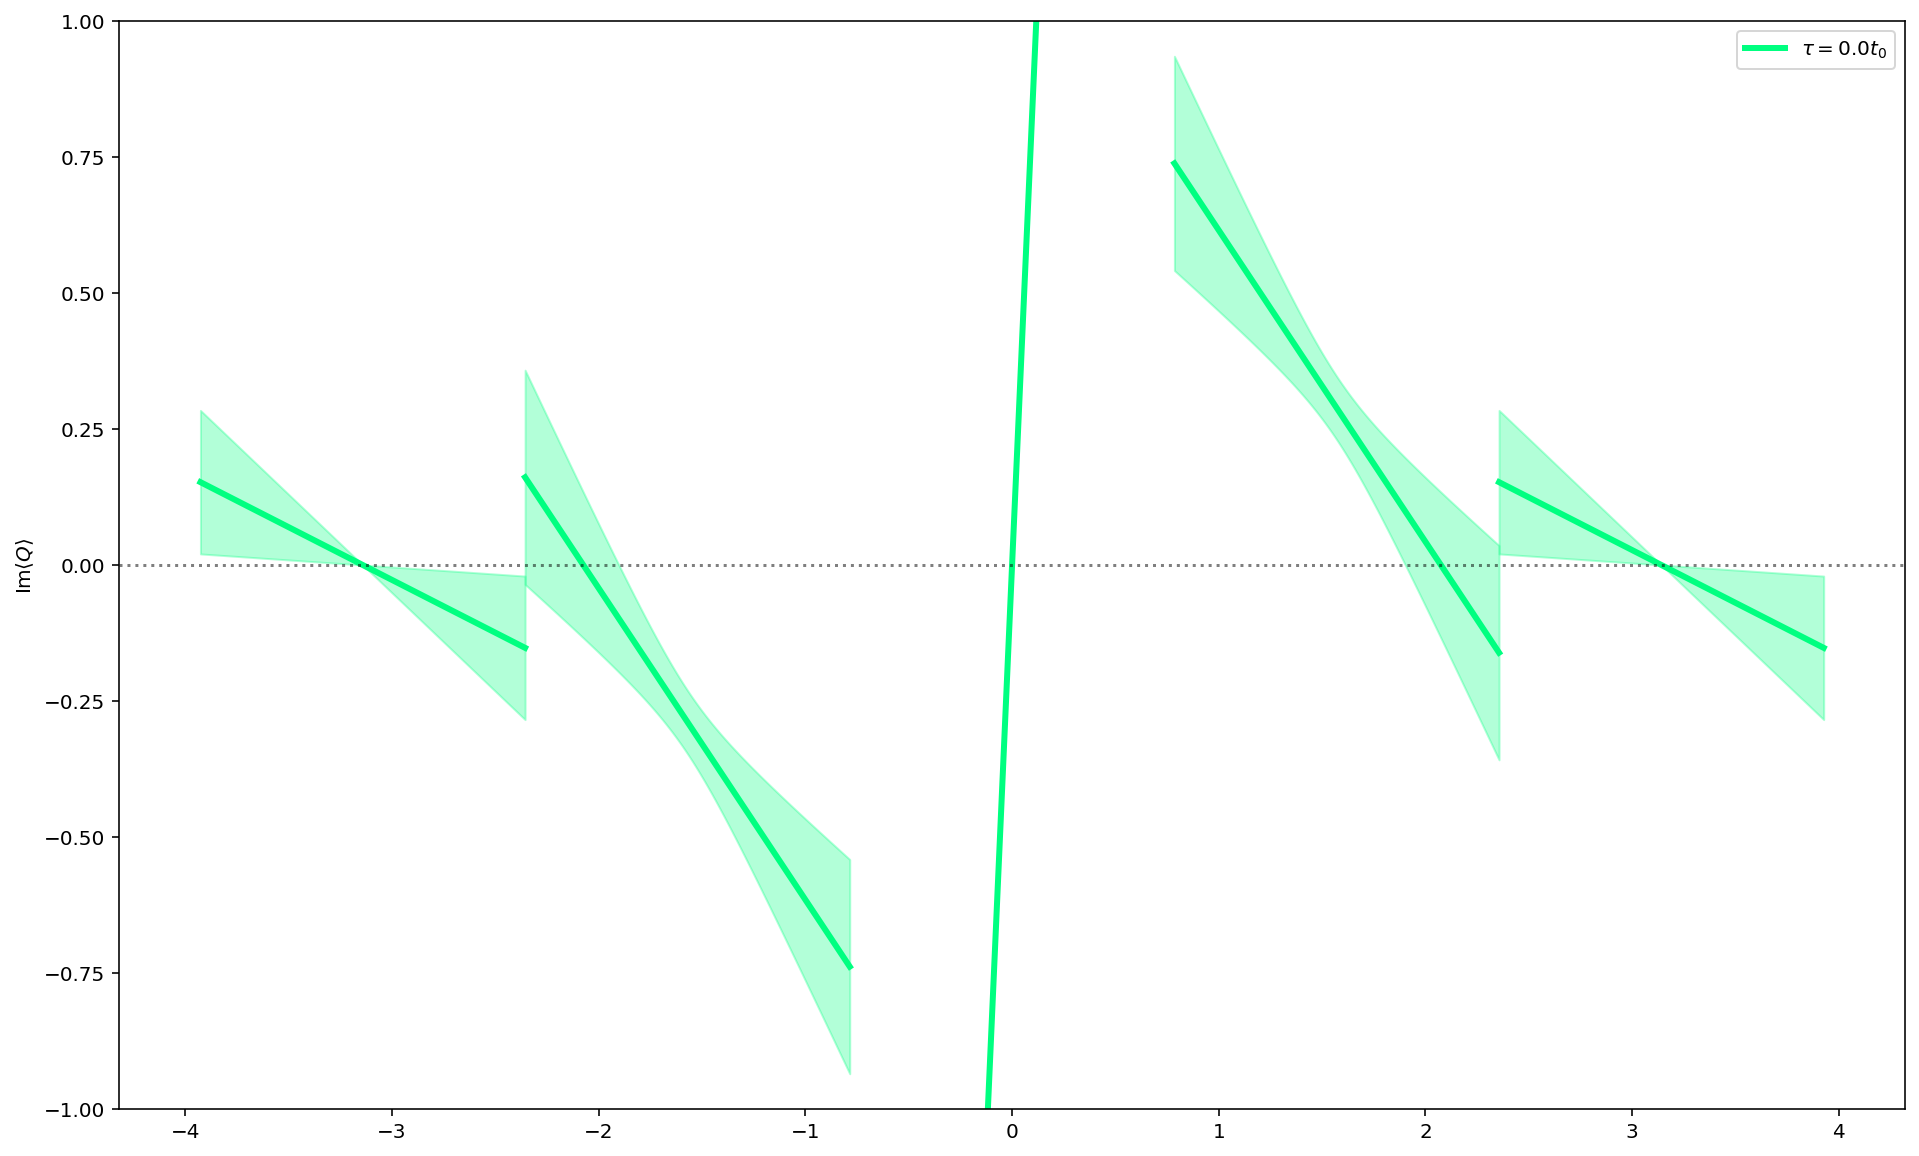

Trial size: 20000
-3.141592653589793
-1.5707963267948966
0.0
1.5707963267948966
3.141592653589793


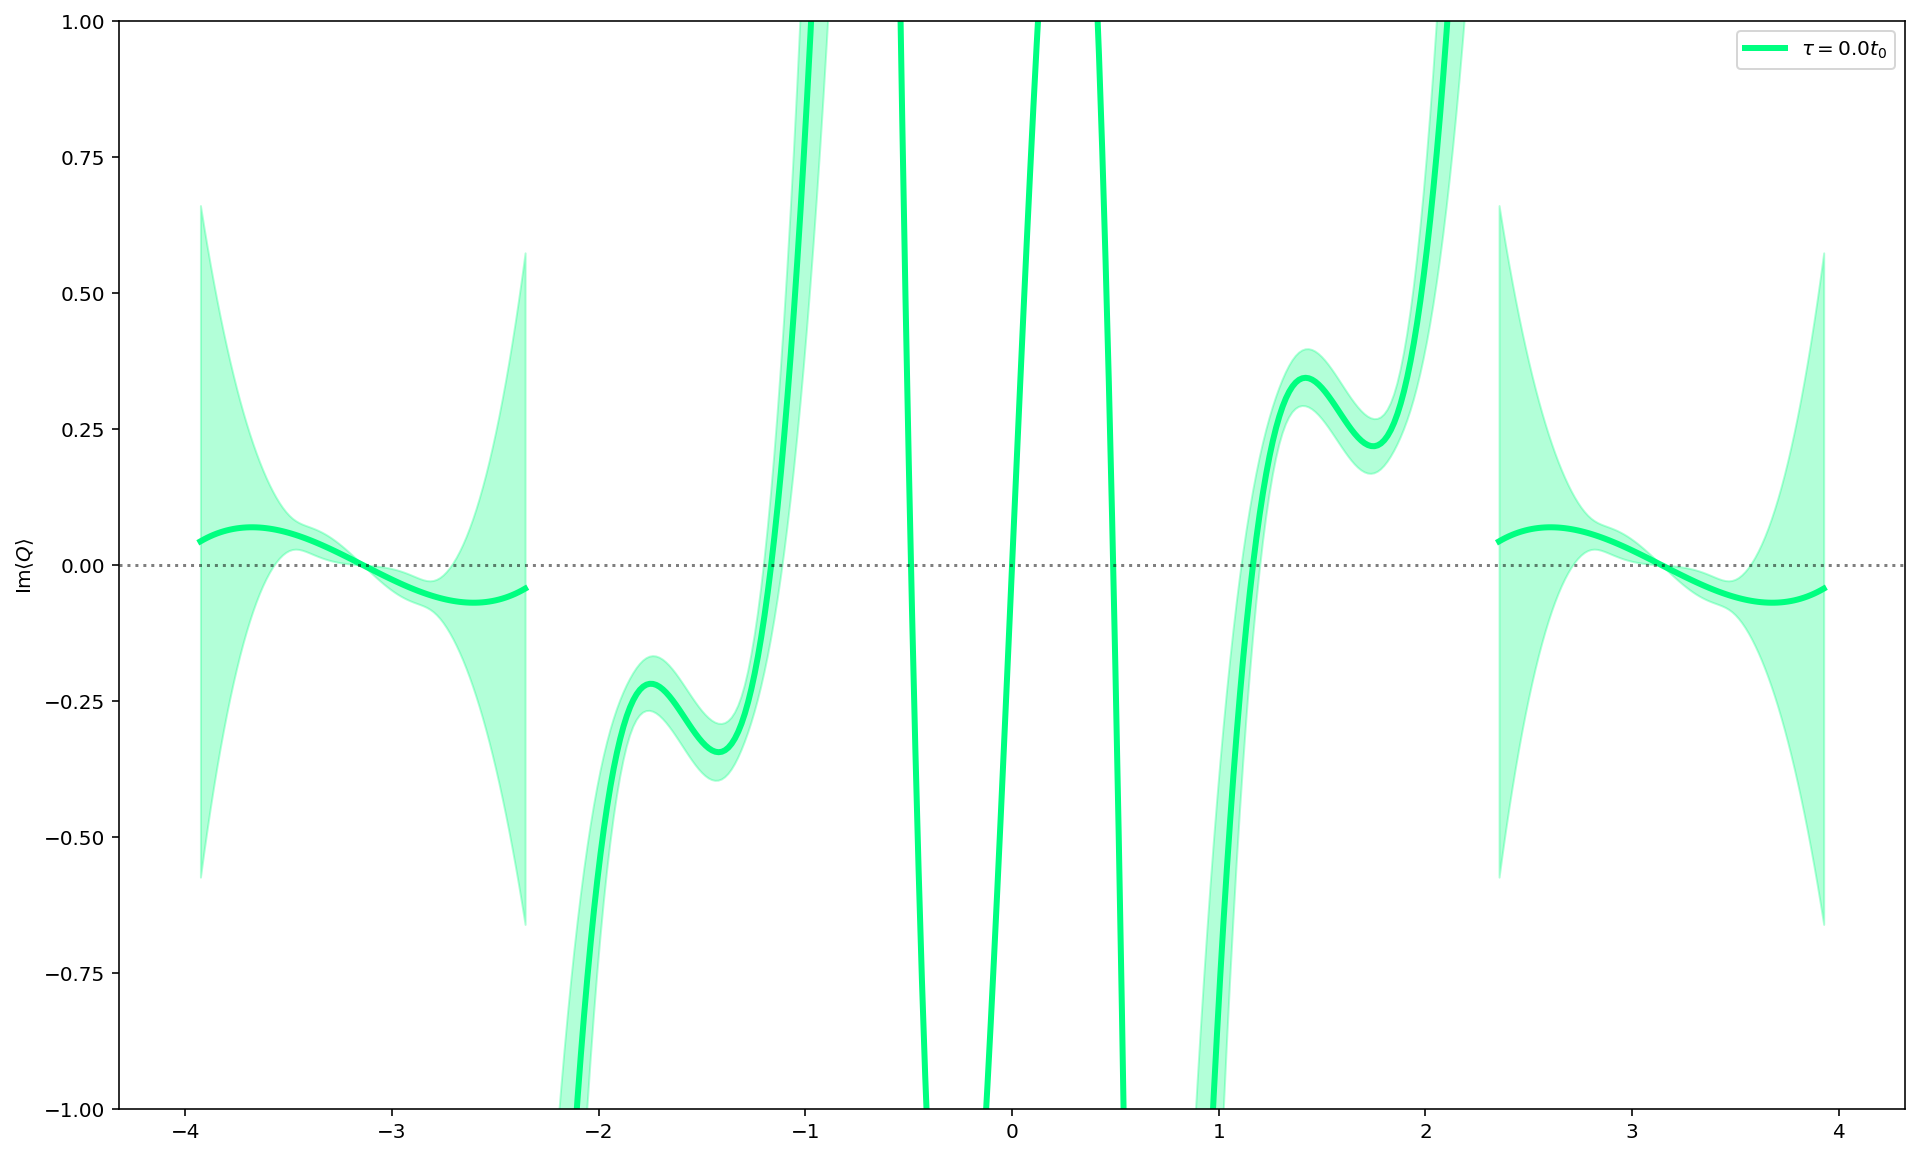

Trial size: 20000
-3.141592653589793
-1.5707963267948966
0.0
1.5707963267948966
3.141592653589793


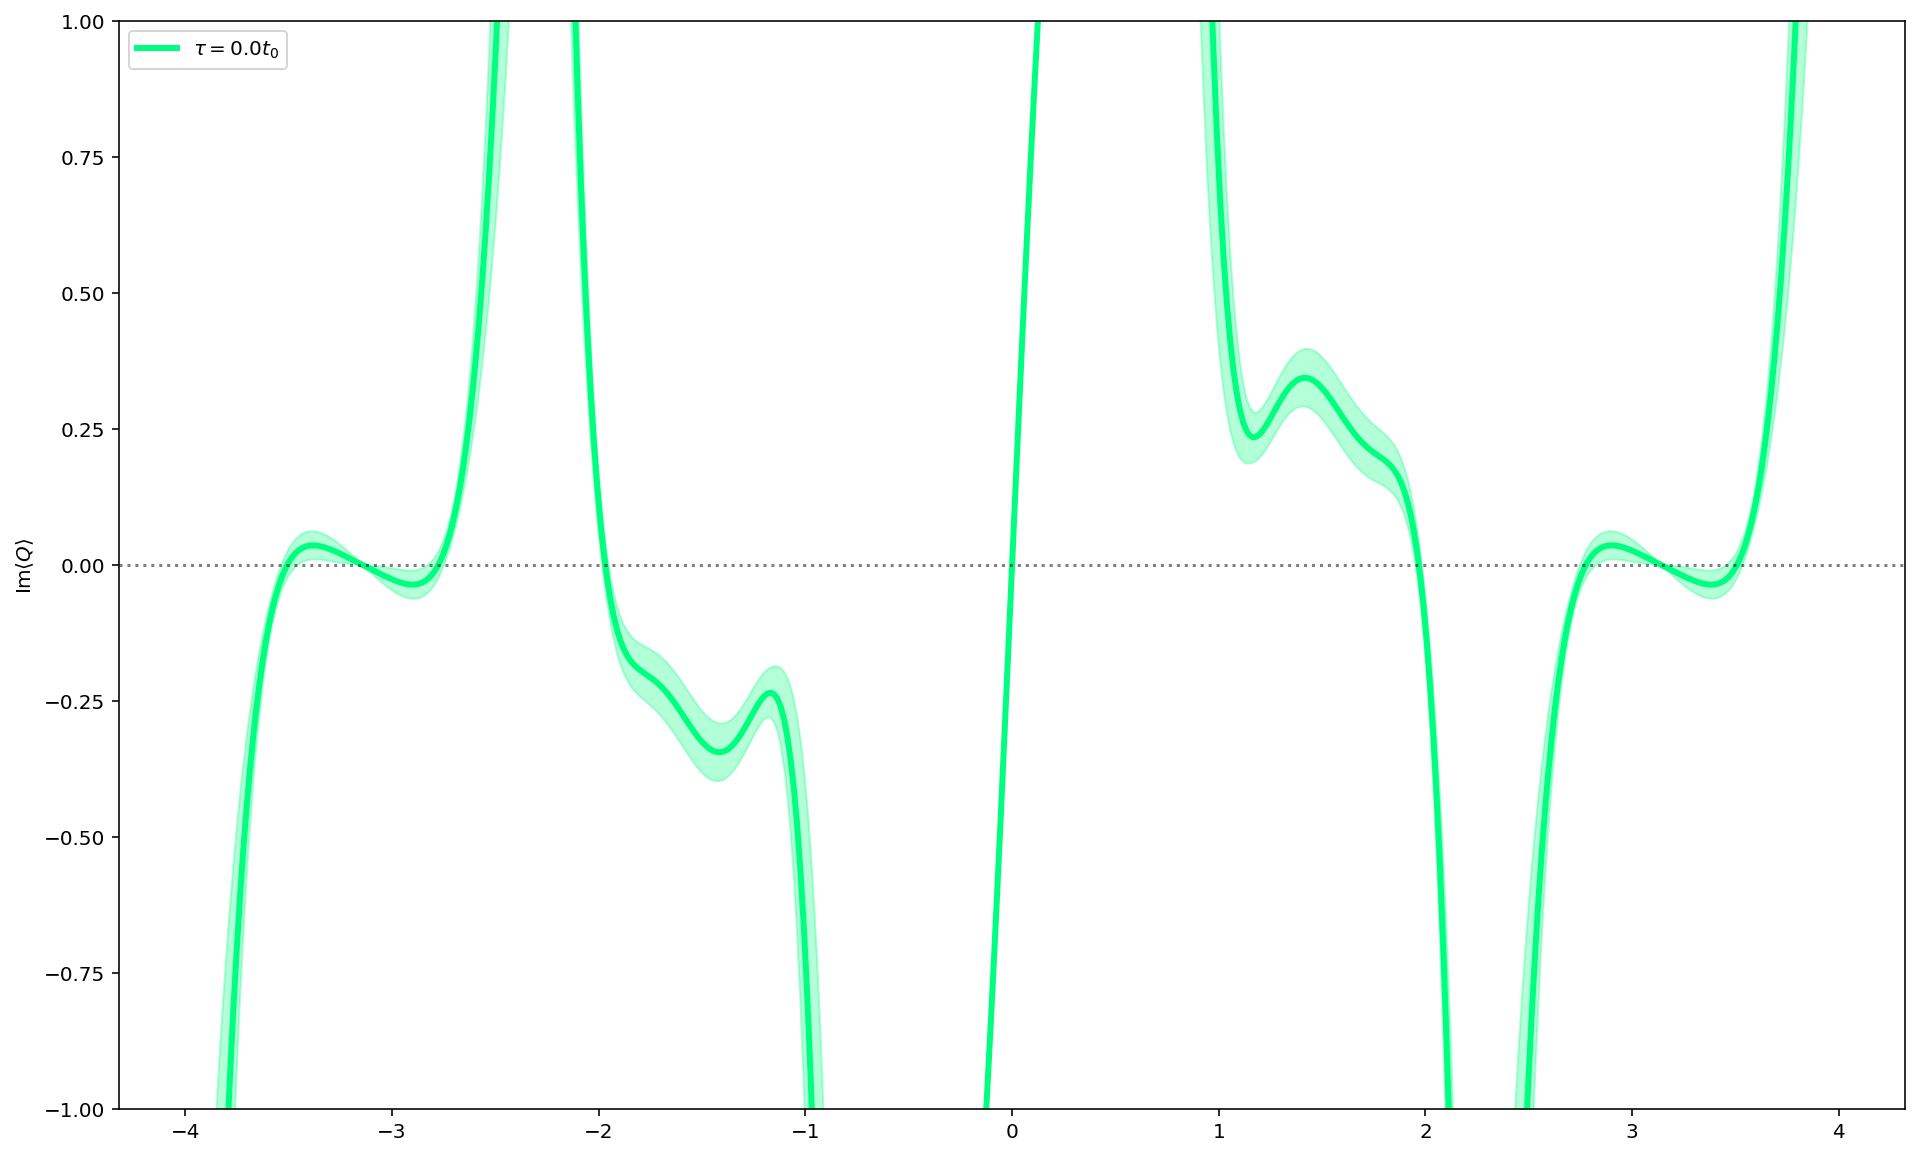

Trial size: 20000
-3.141592653589793
-1.5707963267948966
0.0
1.5707963267948966
3.141592653589793


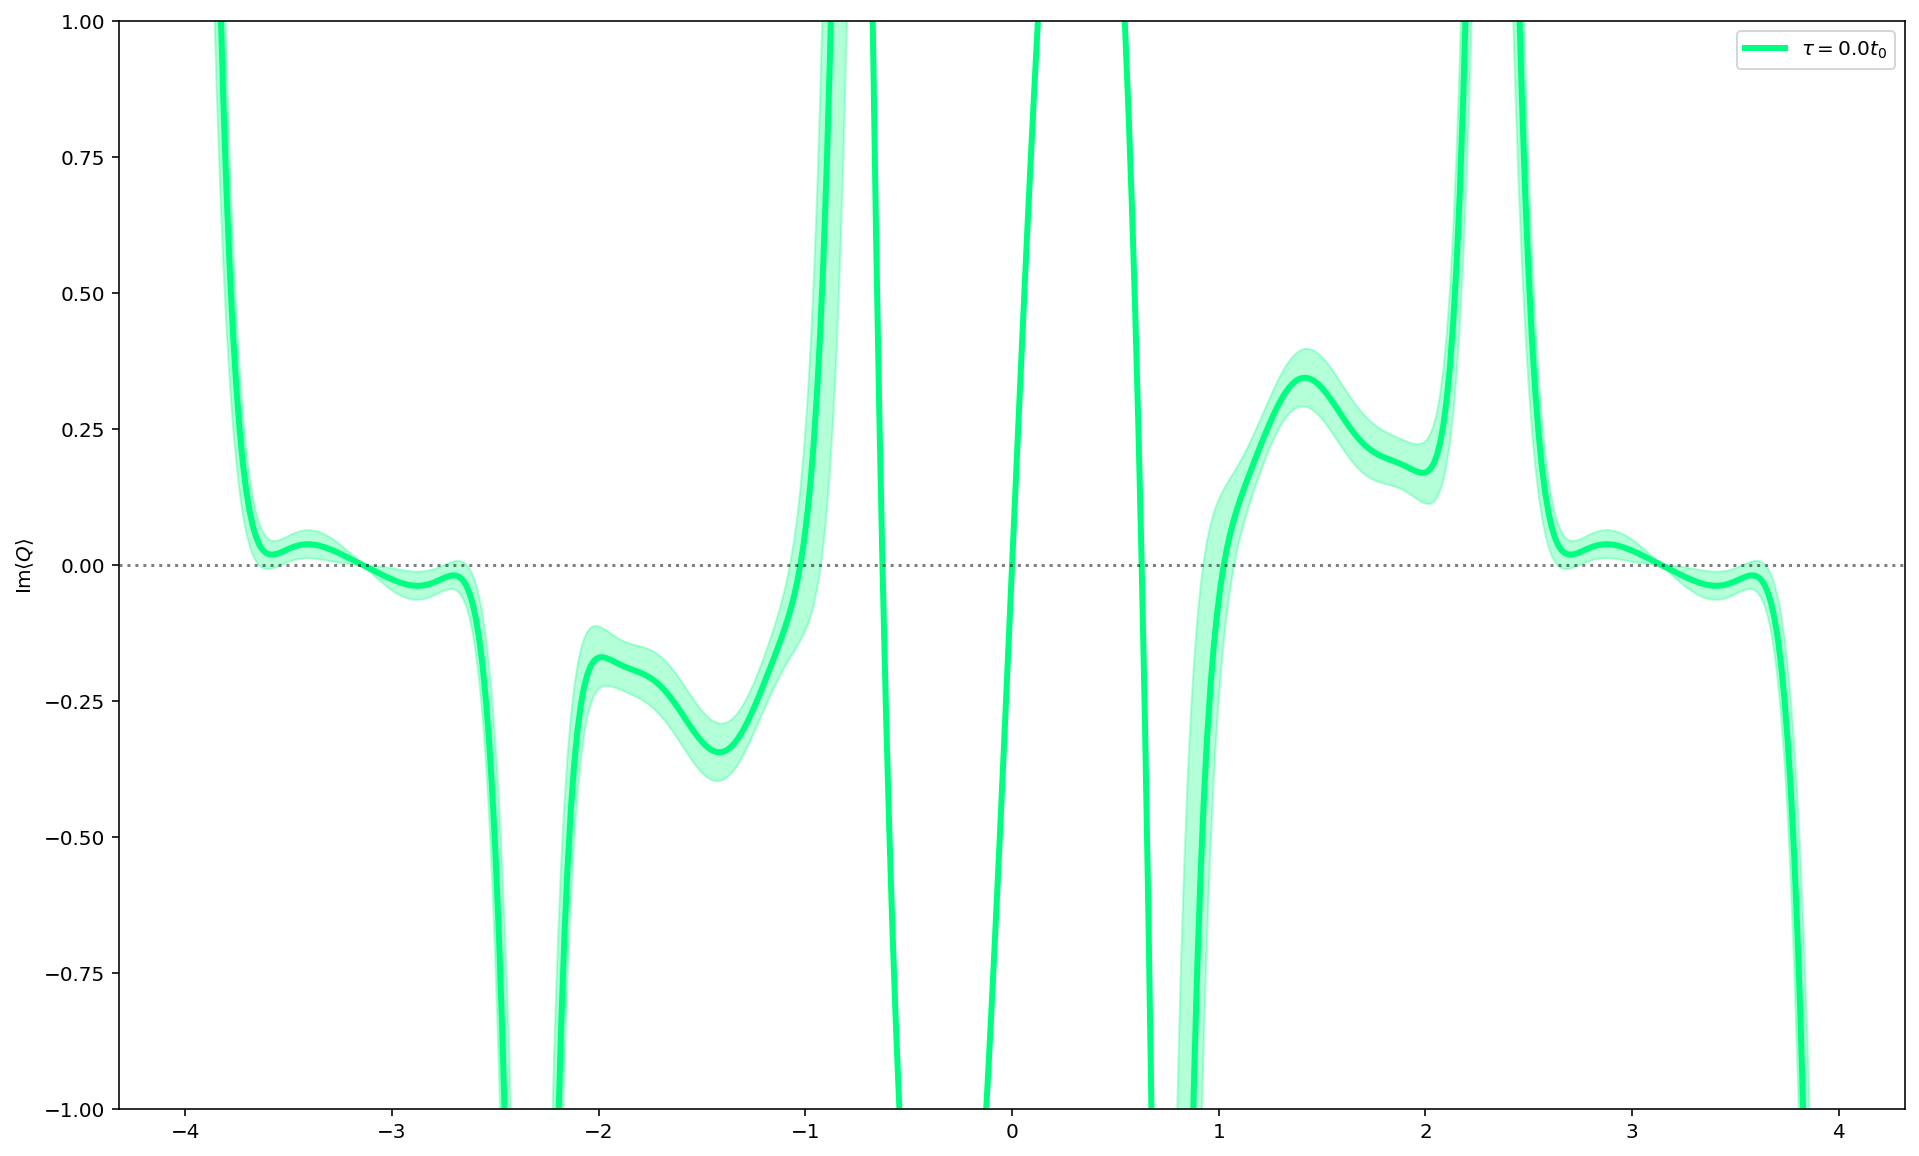

Trial size: 20000
-3.141592653589793
[ 8.556e-04+0.000e+00j  2.467e+41+0.000e+00j  1.362e+39+0.000e+00j
  7.026e+32+0.000e+00j  1.071e+31+0.000e+00j  6.671e+24+0.000e+00j
  1.940e+23+0.000e+00j -3.270e+23+0.000e+00j -1.270e+17+1.494e+17j
 -1.270e+17-1.494e+17j  1.362e+16+0.000e+00j  3.554e+15+0.000e+00j
  2.146e+13+0.000e+00j -1.380e+12+0.000e+00j -1.298e+09+2.131e+09j
 -1.298e+09-2.131e+09j  4.780e+08+0.000e+00j -9.220e+07+0.000e+00j
  9.485e+05+0.000e+00j  1.853e+05+0.000e+00j  4.352e+04+0.000e+00j
 -3.669e+04+0.000e+00j  2.503e+01+0.000e+00j -3.546e+02+0.000e+00j]


Exception: Not positive definite

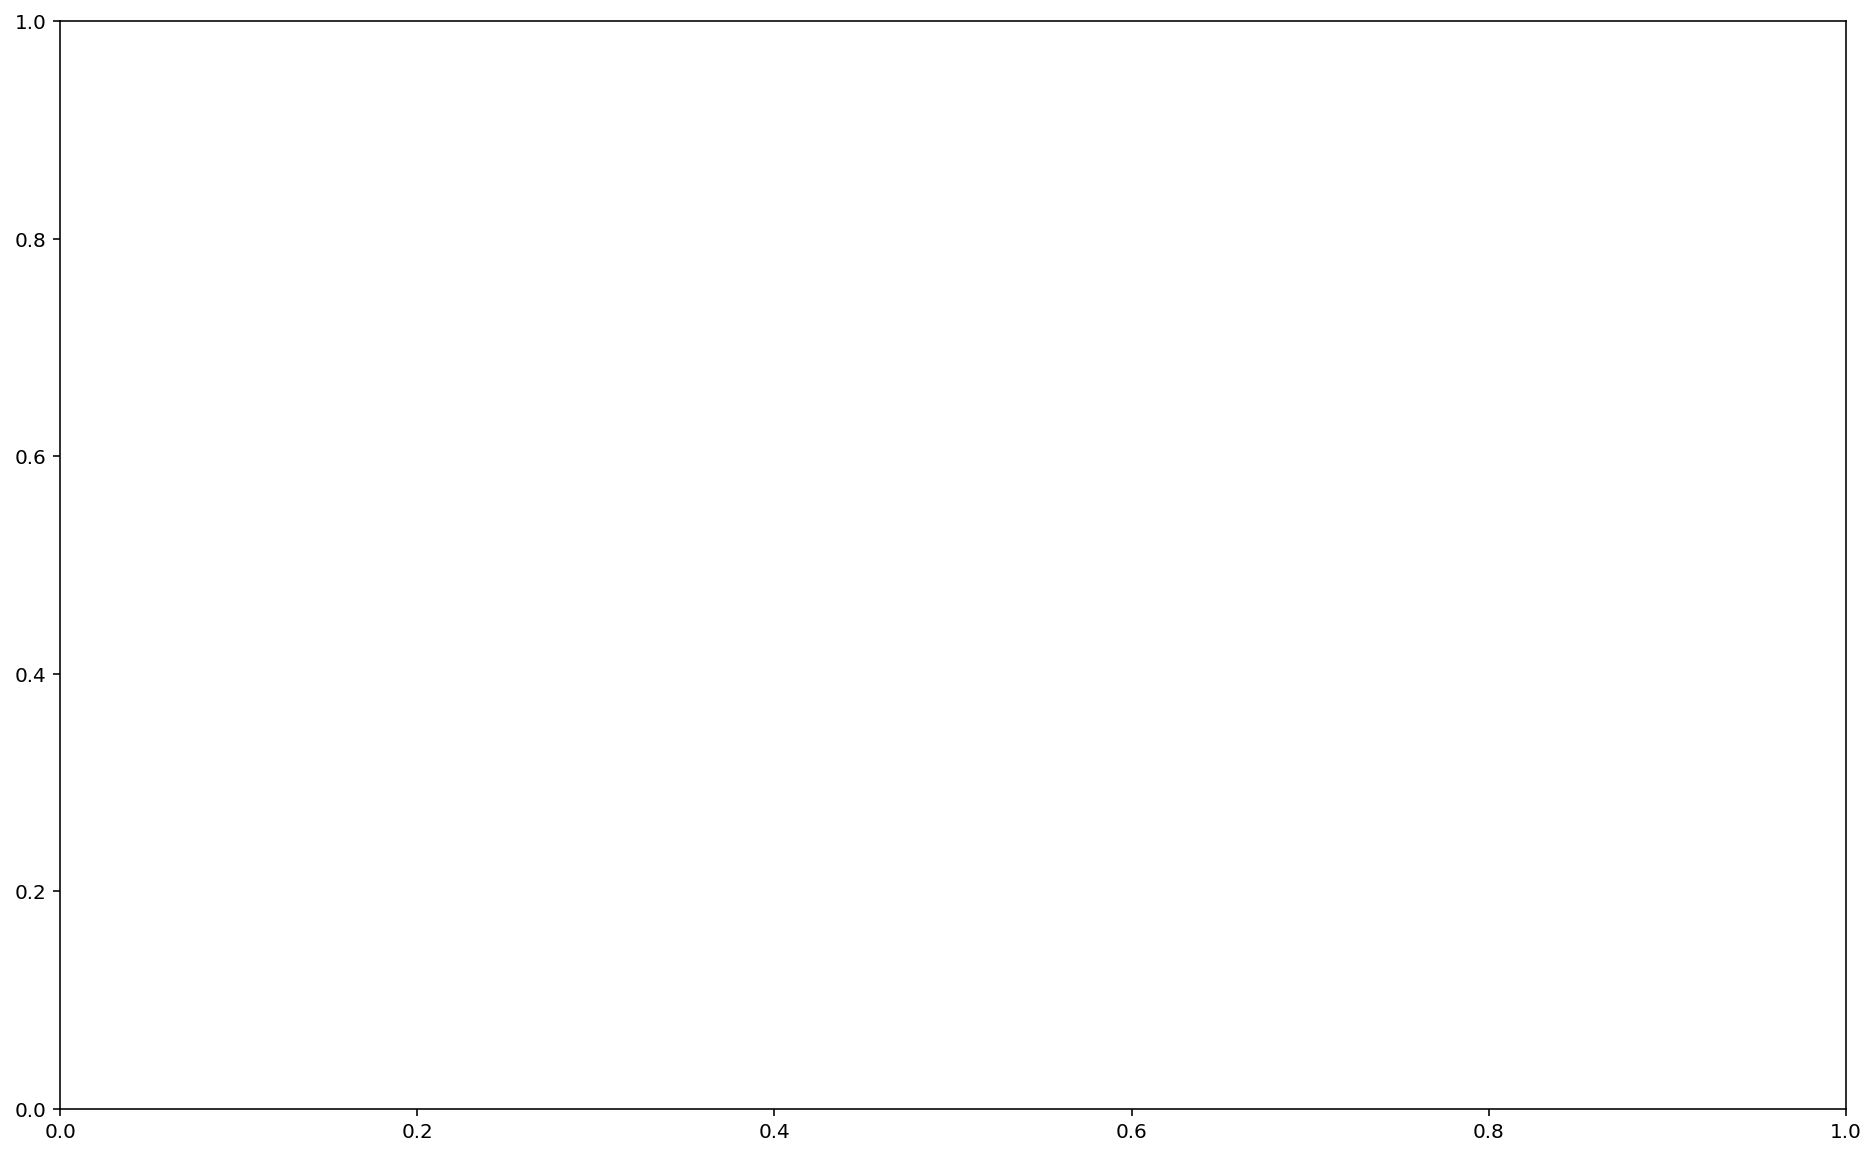

In [106]:
# effect of order


PI = np.pi
theta0s = np.linspace(-1, 1, 5) * PI

fill_width = True
plot_real = False

if fill_width:
    width = 1/(theta0s.size - 1) * PI
else: 
    width = 0.5
    
range_thetas = np.linspace(-width, width, 100)

orders = [2,4,6,8,24]
L = 54


for order in orders:
    data = get_data("small_lattice")
    fig,axes = plt.subplots(1,1,figsize=(16,10),squeeze=False)
    axes = axes[:,0]
    t0 = bietenholz_params[bietenholz_params.L == L].iloc[0].t0

    if theta0 == 0.: theta0 = 2*np.pi
    num_sectors = int(2*np.pi / theta0) # this is actually a signed value

    taus = [0.]

    cs = cm.get_cmap('winter', len(taus))

    for ci,tau in enumerate(taus):

        errQs = np.zeros_like(range_thetas)
        Qs = np.zeros_like(range_thetas)
        c = cs(ci)

        trial = data[(round(data['tau'],10) == round(tau*t0,10)) & (data['L'] == L)]
        print(f"Trial size: {trial.Q.size}")
        for j,theta0 in enumerate(theta0s):
            print(theta0)


            if theta0 == 0.:
                num_sectors = 1
            else:
                num_sectors = int(2*np.pi / theta0) # this is actually a signed value

            thetas = range_thetas + theta0

            for i,theta in enumerate(thetas):
                cumsum = gvar(0,0)
                for k in range(abs(num_sectors)):
                    phase = np.exp(2j*np.pi*k/num_sectors)
                    subtrial = trial[np.abs( np.exp(1j*theta0*trial.Q) - phase ) < 0.0001]
                    Q_samples = subtrial.Q.to_numpy().astype(np.double)
                    N = subtrial.Q.size
                    if subtrial.size==0: 
                        raise Exception(f'Empty trial, most likely caused by too many sectors (you are using {num_sectors})')

                    Q_powers = [0.] # start with 0. so that indices line up with powers
                    # in order to calculate covariances, we need twice the order
                    for n in range(1,2*order+1): 
                        Q_powers.append( np.mean(Q_samples**n) )

                    Q_powers = np.array(Q_powers)
                    means = Q_powers[1:order+1]
                    covariances = np.array([ [ (Q_powers[m+n] - Q_powers[m]*Q_powers[n])/N for m in range(1,order+1)] for n in range(1,order+1)])

                    if not np.all(np.linalg.eigvals(covariances) + 0.0000001 > 0):
                        print(np.linalg.eigvals(covariances))
                        raise Exception("Not positive definite")

                    Q_gvars = gvar(means, covariances)


                    for n in range(order):
                        factor =  (1j*(theta - theta0))**n / np.math.factorial(n) * phase
                        if plot_real:
                            cumsum += np.real(factor) * Q_gvars[n]
                        else:
                            cumsum += np.imag(factor) * Q_gvars[n]

                Qs[i] = cumsum.mean
                errQs[i] = cumsum.sdev

            label = f"$\\tau = {tau}t_0$" if j==0 else None


            axes[0].plot(thetas, Qs, label=label, c=c, lw=3)
            axes[0].fill_between(thetas, Qs + errQs, Qs - errQs, alpha=0.3,color=c)

    axes[0].set_ylabel(r"$\mathrm{Im}\langle Q \rangle$")

    for ax in axes:

        ax.set_ylim((-1,1))
        ax.legend()
        ax.axhline(0.,c='k',alpha=0.5,ls=':')
    plt.show()

    #     full_thetas = np.linspace(-PI,PI,100)
    #     beta = 1.743
    #     Z = full_thetas * np.exp(-full_thetas**2 * beta)
    #     Q = -1j * np.gradient( np.log(Z), full_thetas)
    #     ax.plot(full_thetas, np.imag(Q))
    


In [162]:
(7213723.335 - 7006.184**2)/N

-8548.97731867211

In [150]:
Q = gvar(909206,12455) 
f = -9.68812003968254e-08
print((f * Q))
(Q * f).sdev

-0.0881(12)


0.0012066553509424603

In [26]:
# # effect of order

# from matplotlib import cm

# data = get_data()


# thetas = np.linspace(-1, 1, 101)

# order = 10

# cs = cm.get_cmap('winter', maxorder)

# for j,p in bietenholz_params.iterrows():
    
#     fig,ax = plt.subplots(1,1,figsize=(16,20))
#     Qs = np.zeros_like(thetas, dtype=complex)
    
#     trial = data[(round(data['tau'],10) == round(0.*p.t0,10)) & (data['L'] == p.L)]
# #     print(p.L,":\t", end='')
#     for i,theta in enumerate(thetas):
#         cumsum = 0
#         for n in range(order):
#             cumsum += (1j*theta)**n / np.math.factorial(n) * (trial.Q**(n+1)).mean()

#         Qs[i] = cumsum

#     ax.plot(thetas, np.imag(Qs), label=f"{order} terms", c=c, lw=3)
    
#     ax.set_title(f"L = {p.L}")

# for ax in axes:
#     ax.set_ylim((-10,10))
#     ax.legend()
        
        
        




4.172

In [130]:
x,y =gvar(np.array([1,1]), np.eye(2))
x+y

2.0(1.4)

In [132]:
x,y =gvar(np.array([1,1]), np.ones((2,2)))
x.sdev

1.0

In [137]:
(-1*x).sdev

1.0

In [73]:
Q = (4*np.random.normal(size=1000)).astype(int)
Q

array([ -1,   0,  -6,   2,  -3,  -2,   1,   0,   0,   2,  -7,   4,   7,
         2,  -2,   7,  -1,   5,   1,  -1,   2,  -2,   0,   1,   1,   5,
         1,  -2,   1,   0,   2,  -2,   0,   4,   7,  -3,   4,   1,   3,
        -1,   3,   2,   1,  -7,  -9,  -5,  -2,   1,  -6,   6,  -3,   0,
         4,   3,  -1,   2,   0,  -2,   0,   2,   6,  -1,   2,  -1,   0,
         7,  -2,  -6,  -1,   6,   1,   8,   0,   0,  -3,  -3,  -2,   0,
         7,   2,  -5,   2,  -2,   0,   2,  -3,   0,  -4,   0,   0,  -2,
         8,   0,   0,  -6,  -5,  -3,   1,  -4,   0,  -6,   1,   2,  -2,
         0,  -4,   0,  -2,   0,   4,  -2,  -1,  -9,  -5,  -3,   5,   3,
        10,   0,  -1,   2,  -4,   4,   6,  -6,   2,   9,  -2,   2,  -1,
        -1,  -5,   4,   1,   5,   0,   0,   1,   0,  -1,   9,  -4,  -4,
        -6,  -1,   2,   1,  -4,   3,   0,   2,   0,  -3,   0,  -3,   0,
        -3,  -3,   0,   3,  -1,  -3,  -1,   0,   4,   0,   0,  -3,  -3,
        -5,   5,  -4,   1,  -1,  -2,  -3,  -5,   3,   8,  -2,   

Text(0.5, 0, '$Q$')

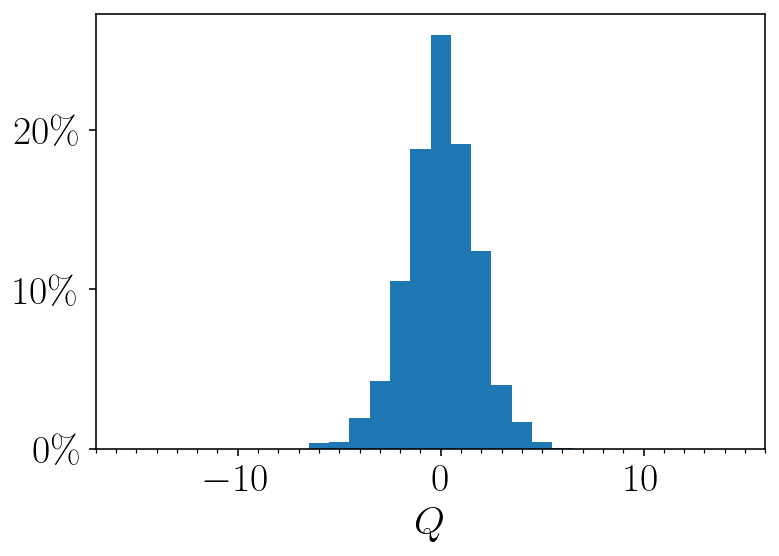

In [79]:
from matplotlib.ticker import MultipleLocator
p = bietenholz_params.iloc[7]
trial = data[(round(data['tau'],10) == round(tau*p.t0,10)) & (data['L'] == p.L)]
Qs = trial.Q.to_numpy()

bins = np.arange(-np.amax(np.abs(Qs)), np.amax(np.abs(Qs))+1) - 0.5
plt.hist(Qs, bins=bins)

def formatter(x,y):
    return f"${int(x / Qs.size * 100)}\%$"
plt.gca().yaxis.set_major_formatter(formatter)
plt.gca().xaxis.set_minor_locator(MultipleLocator(1))
plt.xlabel("$Q$")

In [2]:
trial

NameError: name 'trial' is not defined

In [54]:
data.L.unique()

array([ 24, 180])

10000 measurements
10000 measurements
10000 measurements
10000 measurements
10000 measurements
10000 measurements
10000 measurements
10000 measurements
10000 measurements
10000 measurements
10000 measurements
10000 measurements
10000 measurements
10000 measurements
10000 measurements
10000 measurements
10000 measurements
10000 measurements
10000 measurements
10000 measurements
10000 measurements
10000 measurements
10000 measurements
10000 measurements
[0.0, 1.0, 5.0]


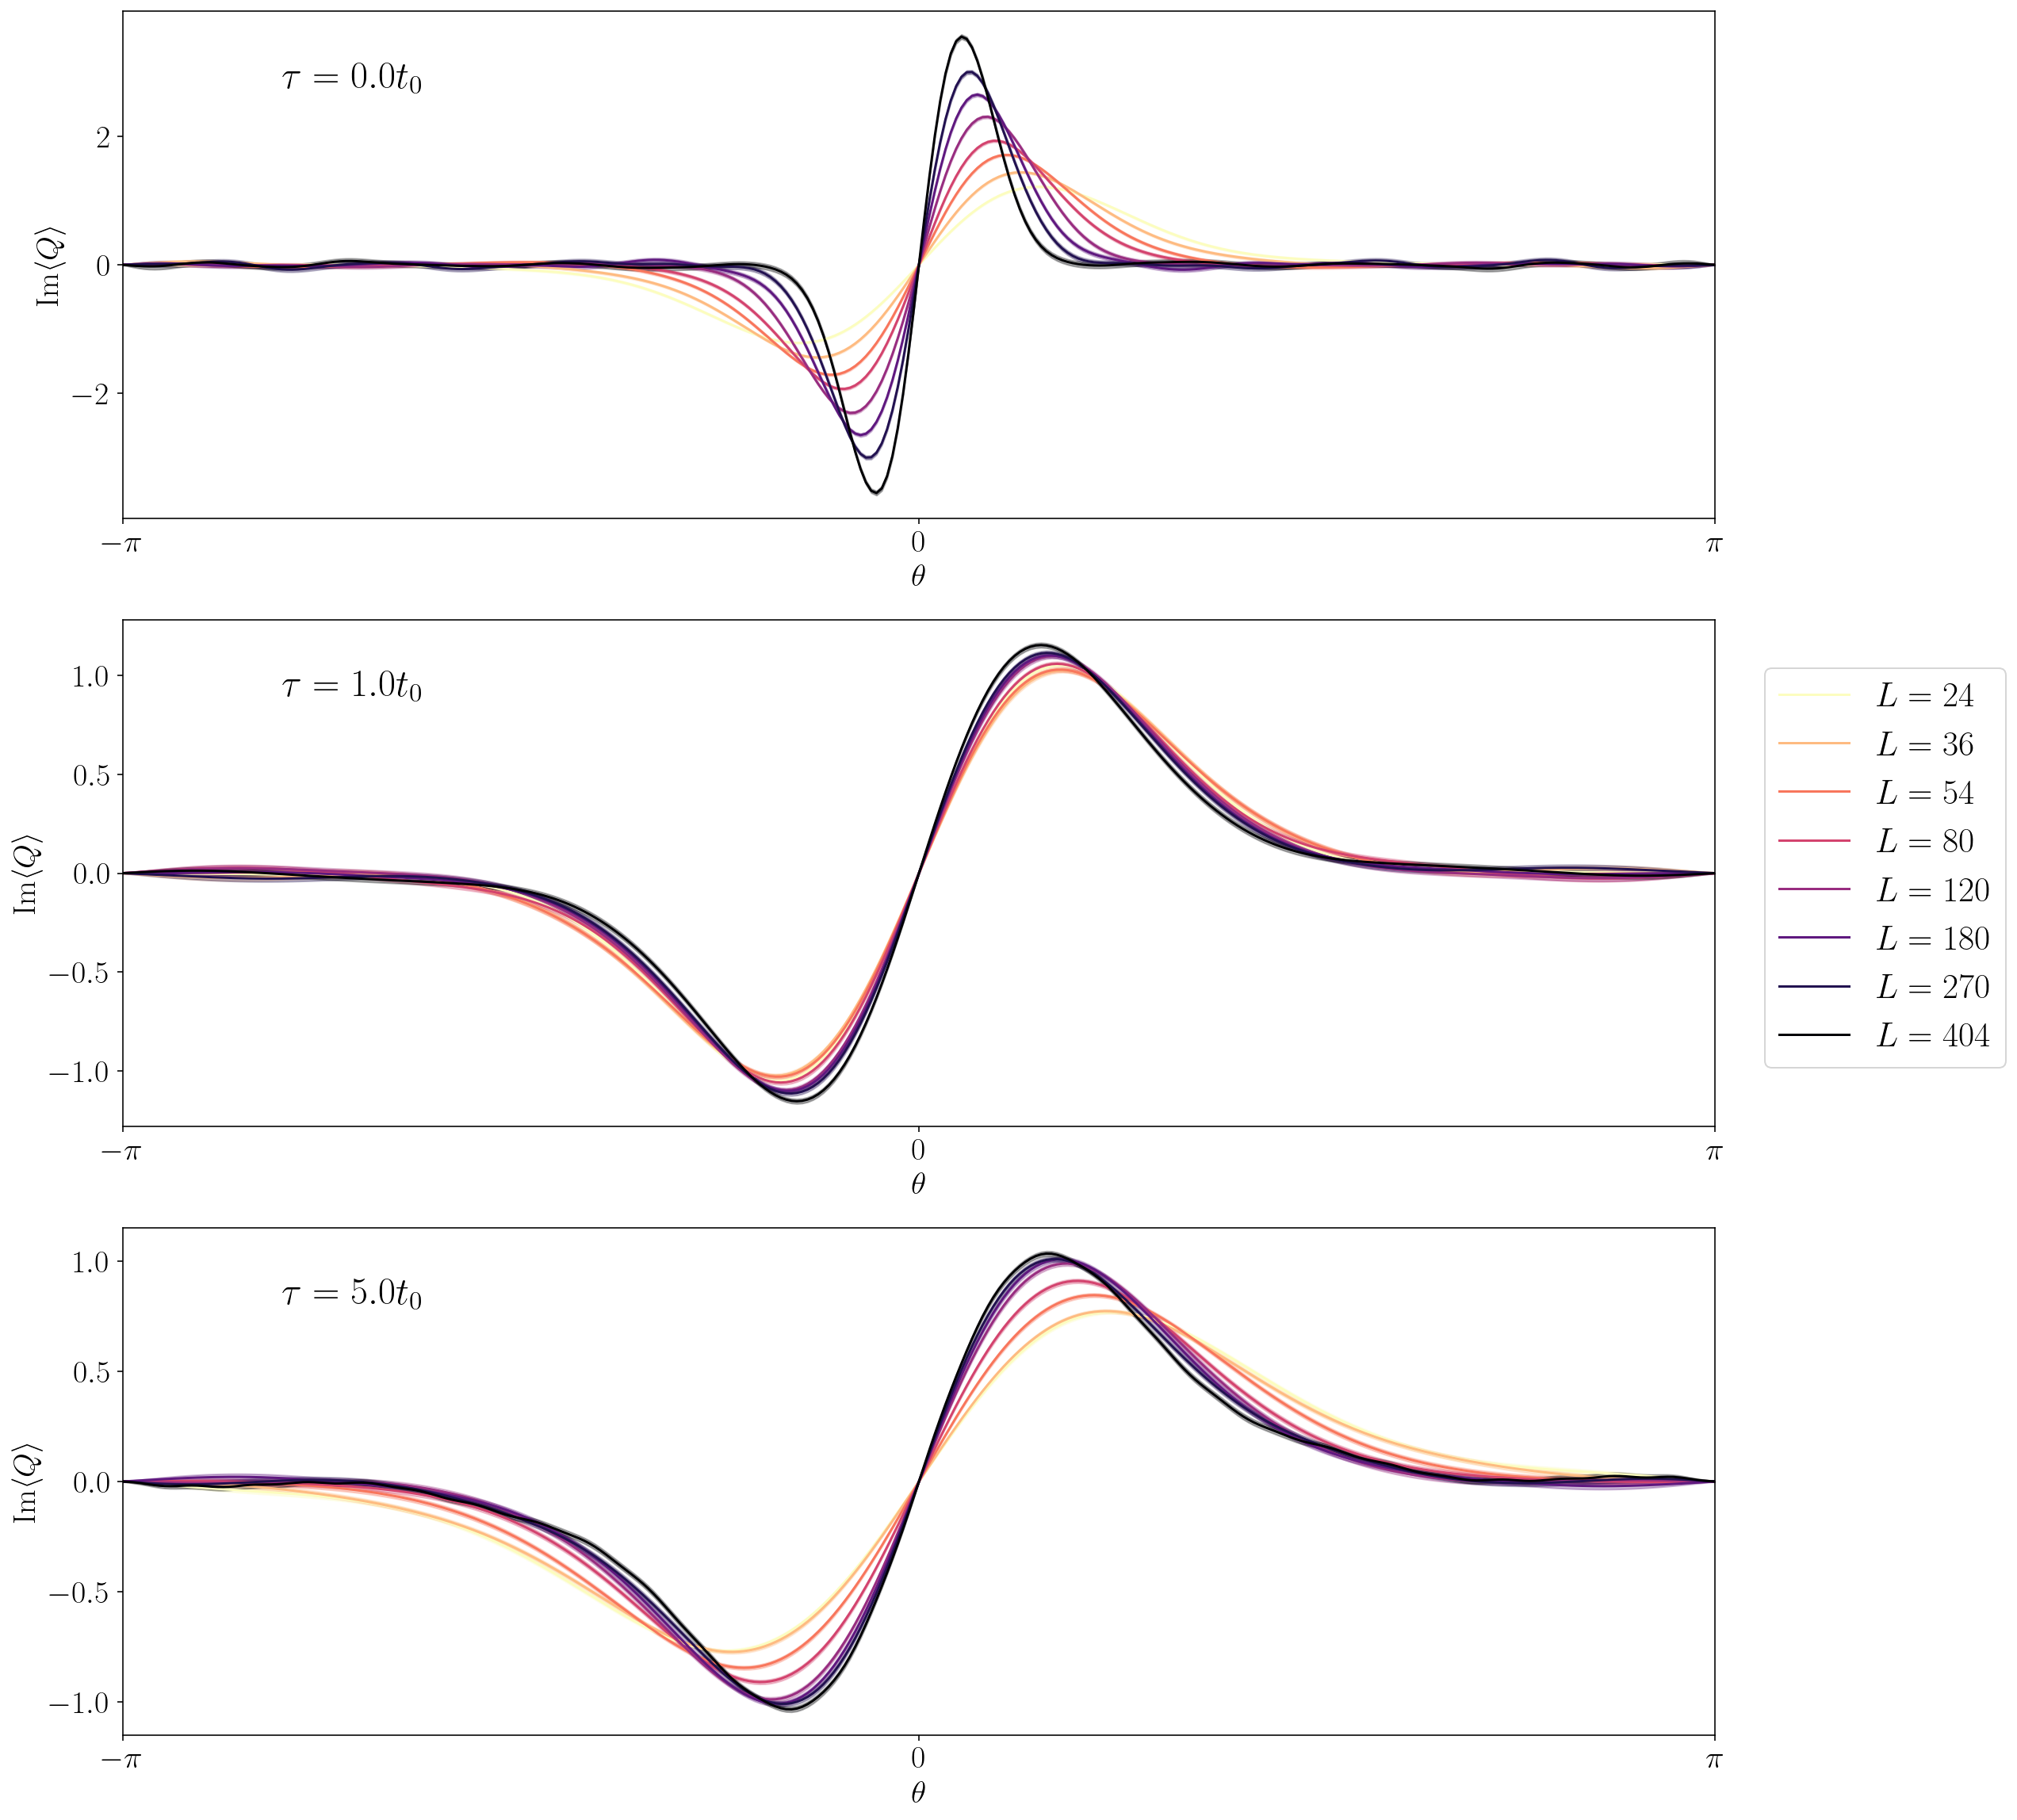

In [46]:
from scipy.stats import sem

data = get_data("data5_fixed")

Ls    = 54
nthetas = 301

fig, axes = plt.subplots(3,1,figsize=(18,20), squeeze=False, sharey=False)
#fig, axes = plt.subplots(2,2,figsize=(16,10), squeeze=False)
axes = [ax for row in axes for ax in row] # flatten axes

#fig2, axes2 = plt.subplots(2,2,figsize=(16,10), squeeze=False, sharey=True)
#axes2 = [ax for row in axes2 for ax in row] # flatten axes

cs = cm.get_cmap('magma_r', len(bietenholz_params))

plot_taus = [0., 1., 5.]

for tau,ax in zip(plot_taus,axes):
    lines = []
    for i,p in bietenholz_params.iterrows():
        #t0 = bietenholz_params[bietenholz_params.L == L].t0.iloc[0]
        trial = data[(round(data['tau'],10) == round(tau*p.t0,10)) & (data['L'] == p.L)]
        
        thetas = np.linspace(-np.pi, np.pi, nthetas)
        iQs = np.zeros_like(thetas)
        iQ_errs = np.zeros_like(thetas)

        if trial.size == 0: continue

        Q = trial.Q.to_numpy()
        print(Q.size,"measurements")
        for j,theta in enumerate(thetas):
            phased_iQ = np.imag( Q*np.exp(1j*theta*Q) )
            iQs[j] = np.mean(phased_iQ)
            iQ_errs[j] = sem(phased_iQ)

        l, = ax.plot(thetas, iQs, label=f"$L={int(p.L)}$", color=cs(i))
        
        Dx = 30
        #ax2.plot(thetas, np.roll(np.real(np.fft.fft(iQs)), nthetas//2), label=f"$L={int(p.L)}$", color=cs(i))  
        
        lines.append(l)
        
        ax.fill_between(thetas, iQs + iQ_errs, iQs - iQ_errs, alpha=0.3, color=cs(i))

    ax.text(0.1,0.85,f"$\\tau={tau}t_0$",transform=ax.transAxes, size='large')
    ax.set_xlim((-np.pi, np.pi))
    #ax2.set_xlim((-0.3, 0.3))
    
    ax.set_xlabel(r"$\theta$")


    ax.set_xticks([-np.pi, 0., np.pi])
    ax.set_xticklabels([r'$-\pi$',r'$0$',r'$\pi$'], fontsize=20)
    
    ax.set_ylabel(r"$\mathrm{Im}\langle Q \rangle$")

plt.figlegend(lines,[f"$L={L}$" for L in bietenholz_params.L], bbox_to_anchor = (1.05, 0.6))
print(plot_taus)


